# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [1]:
version_number = "mixed_full_augmented"

In [2]:
from yolov3.models import Darknet

In [3]:
bs = 8
nepochs = 50
ncpu = 6
gradient_accumulations = 2
evaluation_interval = 1
checkpoint_interval = 10
img_size = 416

In [4]:
# from __future__ import division

from yolov3.models import *
from yolov3.utils.logger import *
from yolov3.utils.utils import *
from yolov3.utils.augmentations import *
from yolov3.utils.datasets import *
from yolov3.utils.parse_config import *
from yolov3.test import evaluate

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config("tuttifruti.data")
#data_config = { line.split()[0] : line.split()[1] for line in open("yolov3/config/jose.data") }

#parse_data_config(opt.data_config)bb
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

print(class_names)

# Initiate model
model = Darknet("tuttifruit.cfg").to(device)#, img_size=img_size).to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint

['ring0', 'ring1', 'ring2', 'ring3']


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.9, aff

In [5]:
os.makedirs(version_number, exist_ok=True)
os.chdir(version_number)

In [15]:
#model.load_state_dict(torch.load("mixed_yolov3_v3_ckpt_40.pth"))

<All keys matched successfully>

In [8]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/')
plot_interval = 100

In [7]:
# Get dataloader
#For some reason augment or multiscale fails
dataset = ListDataset(train_path, multiscale=True, img_size=img_size, transform=AUGMENTATION_TRANSFORMS)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=ncpu,
    pin_memory=False,
    collate_fn=dataset.collate_fn)


In [9]:


optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

#logger = Logger("testingyolo/logs")


for epoch in range(nepochs):
    model.train()
    start_time = time.time()
    epoch_loss = 0.0

    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        #print(_)0
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()
        
        epoch_loss += outputs.shape[0] * loss.item()

        writer.add_scalar('Loss/train_batch', loss,(epoch*len(dataloader)+batch_i))

        if batches_done % gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------
        yololoss = [yolo.metrics["loss"] for yolo in model.yolo_layers]
        for i, yloss in enumerate(yololoss):
            writer.add_scalar('Loss/yolo_loss'+str(i), yloss,(epoch*len(dataloader)+batch_i))
        #writer.add_scalar('Loss/yolo_loss1', yololoss[1],(epoch*len(dataloader)+batch_i))
        #writer.add_scalar('Loss/yolo_loss2', yololoss[2],(epoch*len(dataloader)+batch_i))

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, nepochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        if batch_i % plot_interval == 0:
            # Log metrics at each YOLO layer
            for i, metric in enumerate(metrics):
                formats = {m: "%.6f" for m in metrics}
                formats["grid_size"] = "%2d"
                formats["cls_acc"] = "%.2f%%"
                row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
                metric_table += [[metric, *row_metrics]]

                # Tensorboard logging
                """
                tensorboard_log = []
                for j, yolo in enumerate(model.yolo_layers):
                    for name, metric in yolo.metrics.items():
                        if name != "grid_size":
                            tensorboard_log += [(f"{name}_{j+1}", metric)]
                tensorboard_log += [("loss", loss.item())]
                """
                #logger.list_of_scalars_summary(tensorboard_log, batches_done)

            log_str += AsciiTable(metric_table).table
            log_str += f"\nTotal loss {loss.item()}"

            # Determine approximate time left for epoch
            epoch_batches_left = len(dataloader) - (batch_i + 1)
            time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
            log_str += f"\n---- ETA {time_left}"

            print(log_str)
            #break

        model.seen += imgs.size(0)
    
    
    writer.add_scalar('Loss/train_epoch', epoch_loss / len(dataloader), epoch)
    #print ("HERE", len(dataloader), epoch_loss)


    if epoch % evaluation_interval == 0:
        print(log_str)
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        eval_results = evaluate(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=img_size,
            batch_size=1,
        )
        
        if eval_results is not None:
            #check if eval_loss does not crash code
            precision, recall, AP, f1, ap_class, eval_loss = eval_results
            """
            evaluation_metrics = [
                ("val_precision", precision.mean()),
                ("val_recall", recall.mean()),
                ("val_mAP", AP.mean()),
                ("val_f1", f1.mean()),
            ]
            logger.list_of_scalars_summary(evaluation_metrics, epoch)
            """
            # Print class APs and mAP
            ap_table = [["Index", "Class name", "AP"]]
            for i, c in enumerate(ap_class):
                ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
            print(AsciiTable(ap_table).table)
            print(f"---- mAP {AP.mean()}")
            writer.add_scalar('metrics/map_eval', AP.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/precision', precision.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/recall', recall.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/f1', f1.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('Loss/evaluation/validation', eval_loss,int(epoch / evaluation_interval))
            writer.add_scalar('Loss/evaluation/train', epoch_loss / len(dataloader),int(epoch / evaluation_interval))

    if epoch % checkpoint_interval == 0:
        print (log_str)
        torch.save(model.state_dict(), f"mixed_yolov3_v3_ckpt_%d.pth" % epoch)




---- [Epoch 0/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 79.769188    | 71.765572    |
| x          | 0.051477     | 0.073319     |
| y          | 0.104004     | 0.124708     |
| w          | 0.644227     | 0.667110     |
| h          | 0.349348     | 1.131299     |
| conf       | 77.987511    | 69.047806    |
| cls        | 0.632621     | 0.721329     |
| cls_acc    | 53.85%       | 7.69%        |
| recall50   | 0.307692     | 0.000000     |
| recall75   | 0.076923     | 0.000000     |
| precision  | 0.001349     | 0.000000     |
| conf_obj   | 0.561487     | 0.513187     |
| conf_noobj | 0.531270     | 0.493023     |
+------------+--------------+--------------+
Total loss 151.53475952148438
---- ETA 0:24:50.050405

---- [Epoch 0/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 0/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 1.262271     | 1.170725     |
| x          | 0.039618     | 0.032496     |
| y          | 0.082645     | 0.078035     |
| w          | 0.053782     | 0.048985     |
| h          | 0.013128     | 0.040044     |
| conf       | 0.966610     | 0.848508     |
| cls        | 0.106488     | 0.122658     |
| cls_acc    | 92.86%       | 92.86%       |
| recall50   | 0.714286     | 0.785714     |
| recall75   | 0.357143     | 0.500000     |
| precision  | 0.500000     | 0.250000     |
| conf_obj   | 0.789740     | 0.778479     |
| conf_noobj | 0.004266     | 0.003712     |
+------------+--------------+--------------+
Total loss 2.4329967498779297
---- ETA 0:00:22.596717

---- [Epoch 0/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 0/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 255.94it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.22096 |
| 1     | ring1      | 0.69642 |
| 2     | ring2      | 0.47436 |
| 3     | ring3      | 0.70255 |
+-------+------------+---------+
---- mAP 0.5235726211205448

---- [Epoch 0/50, Batch 1124/1125] ----




---- [Epoch 1/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 1.180019     | 1.392678     |
| x          | 0.055752     | 0.031724     |
| y          | 0.010088     | 0.059451     |
| w          | 0.045566     | 0.076444     |
| h          | 0.022932     | 0.041065     |
| conf       | 0.766236     | 0.886579     |
| cls        | 0.279445     | 0.297415     |
| cls_acc    | 75.00%       | 83.33%       |
| recall50   | 0.500000     | 0.500000     |
| recall75   | 0.416667     | 0.333333     |
| precision  | 0.500000     | 0.260870     |
| conf_obj   | 0.728296     | 0.678705     |
| conf_noobj | 0.001865     | 0.002464     |
+------------+--------------+--------------+
Total loss 2.5726966857910156
---- ETA 0:11:10.438576

---- [Epoch 1/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 1/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.883842     | 0.701056     |
| x          | 0.017625     | 0.041426     |
| y          | 0.028141     | 0.035610     |
| w          | 0.020288     | 0.025852     |
| h          | 0.010971     | 0.010350     |
| conf       | 0.681596     | 0.466872     |
| cls        | 0.125220     | 0.120947     |
| cls_acc    | 84.62%       | 92.31%       |
| recall50   | 0.692308     | 0.923077     |
| recall75   | 0.615385     | 0.692308     |
| precision  | 0.473684     | 0.272727     |
| conf_obj   | 0.785566     | 0.875029     |
| conf_noobj | 0.002752     | 0.002068     |
+------------+--------------+--------------+
Total loss 1.5848984718322754
---- ETA 0:00:22.393608

---- [Epoch 1/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 1/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 209.05it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.29622 |
| 1     | ring1      | 0.81215 |
| 2     | ring2      | 0.53746 |
| 3     | ring3      | 0.78768 |
+-------+------------+---------+
---- mAP 0.6083763874840977



---- [Epoch 2/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.865460     | 0.816651     |
| x          | 0.006054     | 0.032624     |
| y          | 0.023757     | 0.037058     |
| w          | 0.028367     | 0.043259     |
| h          | 0.023174     | 0.029468     |
| conf       | 0.642731     | 0.462906     |
| cls        | 0.141377     | 0.211335     |
| cls_acc    | 90.00%       | 80.00%       |
| recall50   | 0.800000     | 0.700000     |
| recall75   | 0.700000     | 0.500000     |
| precision  | 0.615385     | 0.200000     |
| conf_obj   | 0.818335     | 0.876956     |
| conf_noobj | 0.001493     | 0.002000     |
+------------+--------------+--------------+
Total loss 1.6821112632751465
---- ETA 0:12:56.560443

---- [Epoch 2/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 2/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.764071     | 0.684789     |
| x          | 0.026780     | 0.048214     |
| y          | 0.018931     | 0.048365     |
| w          | 0.014172     | 0.012993     |
| h          | 0.005364     | 0.006302     |
| conf       | 0.614565     | 0.466008     |
| cls        | 0.084258     | 0.102906     |
| cls_acc    | 100.00%      | 91.67%       |
| recall50   | 0.750000     | 0.916667     |
| recall75   | 0.750000     | 0.916667     |
| precision  | 0.562500     | 0.275000     |
| conf_obj   | 0.792063     | 0.873786     |
| conf_noobj | 0.002195     | 0.001872     |
+------------+--------------+--------------+
Total loss 1.4488599300384521
---- ETA 0:00:21.981882

---- [Epoch 2/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 2/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 217.93it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.38556 |
| 1     | ring1      | 0.89227 |
| 2     | ring2      | 0.59284 |
| 3     | ring3      | 0.78792 |
+-------+------------+---------+
---- mAP 0.6646486383829482



---- [Epoch 3/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 1.139914     | 1.034077     |
| x          | 0.086063     | 0.085566     |
| y          | 0.010507     | 0.031551     |
| w          | 0.038058     | 0.049649     |
| h          | 0.012161     | 0.012523     |
| conf       | 0.800337     | 0.634368     |
| cls        | 0.192788     | 0.220420     |
| cls_acc    | 85.71%       | 78.57%       |
| recall50   | 0.785714     | 0.714286     |
| recall75   | 0.714286     | 0.714286     |
| precision  | 0.611111     | 0.370370     |
| conf_obj   | 0.754811     | 0.753859     |
| conf_noobj | 0.002130     | 0.001561     |
+------------+--------------+--------------+
Total loss 2.1739912033081055
---- ETA 0:12:48.728119

---- [Epoch 3/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 3/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 1.465938     | 1.210228     |
| x          | 0.047996     | 0.034731     |
| y          | 0.018173     | 0.033226     |
| w          | 0.017796     | 0.131583     |
| h          | 0.022473     | 0.021768     |
| conf       | 1.221917     | 0.881631     |
| cls        | 0.137583     | 0.107289     |
| cls_acc    | 90.00%       | 90.00%       |
| recall50   | 0.500000     | 0.800000     |
| recall75   | 0.400000     | 0.700000     |
| precision  | 0.500000     | 0.400000     |
| conf_obj   | 0.648767     | 0.816392     |
| conf_noobj | 0.001612     | 0.001001     |
+------------+--------------+--------------+
Total loss 2.676165819168091
---- ETA 0:00:22.690104

---- [Epoch 3/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics 

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 3/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 280.89it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.38003 |
| 1     | ring1      | 0.84612 |
| 2     | ring2      | 0.54159 |
| 3     | ring3      | 0.86363 |
+-------+------------+---------+
---- mAP 0.6578411026387456



---- [Epoch 4/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.881219     | 0.768443     |
| x          | 0.033437     | 0.019012     |
| y          | 0.026105     | 0.039328     |
| w          | 0.049663     | 0.044192     |
| h          | 0.025593     | 0.017452     |
| conf       | 0.558975     | 0.507324     |
| cls        | 0.187446     | 0.141134     |
| cls_acc    | 83.33%       | 83.33%       |
| recall50   | 0.666667     | 0.666667     |
| recall75   | 0.666667     | 0.666667     |
| precision  | 0.533333     | 0.222222     |
| conf_obj   | 0.820390     | 0.877525     |
| conf_noobj | 0.002183     | 0.002125     |
+------------+--------------+--------------+
Total loss 1.6496617794036865
---- ETA 0:12:41.734312

---- [Epoch 4/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 4/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.634020     | 0.494108     |
| x          | 0.024954     | 0.028599     |
| y          | 0.014813     | 0.026638     |
| w          | 0.007785     | 0.011281     |
| h          | 0.004388     | 0.005867     |
| conf       | 0.520002     | 0.384995     |
| cls        | 0.062079     | 0.036728     |
| cls_acc    | 92.31%       | 100.00%      |
| recall50   | 0.923077     | 1.000000     |
| recall75   | 0.923077     | 1.000000     |
| precision  | 0.521739     | 0.282609     |
| conf_obj   | 0.901288     | 0.912699     |
| conf_noobj | 0.002570     | 0.001654     |
+------------+--------------+--------------+
Total loss 1.1281280517578125
---- ETA 0:00:21.983952

---- [Epoch 4/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 4/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 310.53it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.58853 |
| 1     | ring1      | 0.92749 |
| 2     | ring2      | 0.81009 |
| 3     | ring3      | 0.87762 |
+-------+------------+---------+
---- mAP 0.8009330156961965



---- [Epoch 5/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.773573     | 0.689613     |
| x          | 0.018255     | 0.032927     |
| y          | 0.018113     | 0.055542     |
| w          | 0.029165     | 0.018691     |
| h          | 0.022852     | 0.013135     |
| conf       | 0.585595     | 0.474597     |
| cls        | 0.099592     | 0.094721     |
| cls_acc    | 92.31%       | 92.31%       |
| recall50   | 0.846154     | 0.846154     |
| recall75   | 0.846154     | 0.615385     |
| precision  | 0.647059     | 0.282051     |
| conf_obj   | 0.850421     | 0.900248     |
| conf_noobj | 0.001905     | 0.001771     |
+------------+--------------+--------------+
Total loss 1.463185429573059
---- ETA 0:13:00.183834

---- [Epoch 5/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    |


---- [Epoch 5/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.600980     | 0.608396     |
| x          | 0.017826     | 0.029058     |
| y          | 0.010536     | 0.024145     |
| w          | 0.016514     | 0.013893     |
| h          | 0.018072     | 0.016150     |
| conf       | 0.392281     | 0.377128     |
| cls        | 0.145751     | 0.148021     |
| cls_acc    | 92.86%       | 92.86%       |
| recall50   | 0.928571     | 0.928571     |
| recall75   | 0.785714     | 0.785714     |
| precision  | 0.722222     | 0.393939     |
| conf_obj   | 0.915476     | 0.901668     |
| conf_noobj | 0.001887     | 0.001382     |
+------------+--------------+--------------+
Total loss 1.2093753814697266
---- ETA 0:00:22.023565

---- [Epoch 5/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 5/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 330.05it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.39518 |
| 1     | ring1      | 0.79737 |
| 2     | ring2      | 0.62931 |
| 3     | ring3      | 0.82475 |
+-------+------------+---------+
---- mAP 0.6616503924452958



---- [Epoch 6/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.897103     | 1.005251     |
| x          | 0.036869     | 0.041627     |
| y          | 0.011176     | 0.050290     |
| w          | 0.036337     | 0.029529     |
| h          | 0.011805     | 0.012466     |
| conf       | 0.514914     | 0.546201     |
| cls        | 0.286001     | 0.325138     |
| cls_acc    | 72.73%       | 66.67%       |
| recall50   | 0.545455     | 0.583333     |
| recall75   | 0.545455     | 0.500000     |
| precision  | 0.400000     | 0.148936     |
| conf_obj   | 0.836716     | 0.832859     |
| conf_noobj | 0.001859     | 0.001865     |
+------------+--------------+--------------+
Total loss 1.9023534059524536
---- ETA 0:13:26.617894

---- [Epoch 6/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 6/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.746006     | 0.636573     |
| x          | 0.039596     | 0.030584     |
| y          | 0.014759     | 0.030968     |
| w          | 0.025518     | 0.023589     |
| h          | 0.029438     | 0.009551     |
| conf       | 0.556344     | 0.504515     |
| cls        | 0.080351     | 0.037364     |
| cls_acc    | 91.67%       | 100.00%      |
| recall50   | 0.833333     | 0.923077     |
| recall75   | 0.666667     | 0.846154     |
| precision  | 0.500000     | 0.292683     |
| conf_obj   | 0.840398     | 0.886584     |
| conf_noobj | 0.001929     | 0.001606     |
+------------+--------------+--------------+
Total loss 1.3825790882110596
---- ETA 0:00:22.354022

---- [Epoch 6/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 6/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 295.62it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.53089 |
| 1     | ring1      | 0.76617 |
| 2     | ring2      | 0.66726 |
| 3     | ring3      | 0.88423 |
+-------+------------+---------+
---- mAP 0.7121379601233917



---- [Epoch 7/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.403756     | 0.580056     |
| x          | 0.016862     | 0.016677     |
| y          | 0.004693     | 0.011966     |
| w          | 0.063133     | 0.033523     |
| h          | 0.013080     | 0.017496     |
| conf       | 0.181761     | 0.430115     |
| cls        | 0.124227     | 0.070278     |
| cls_acc    | 90.91%       | 90.91%       |
| recall50   | 0.909091     | 0.818182     |
| recall75   | 0.818182     | 0.727273     |
| precision  | 0.909091     | 0.333333     |
| conf_obj   | 0.924738     | 0.823390     |
| conf_noobj | 0.000832     | 0.001233     |
+------------+--------------+--------------+
Total loss 0.9838120937347412
---- ETA 0:11:46.377707

---- [Epoch 7/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 7/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 1.450647     | 1.132024     |
| x          | 0.028737     | 0.032431     |
| y          | 0.007362     | 0.027578     |
| w          | 0.027033     | 0.028574     |
| h          | 0.011405     | 0.003528     |
| conf       | 1.095116     | 0.704615     |
| cls        | 0.280994     | 0.335299     |
| cls_acc    | 84.62%       | 84.62%       |
| recall50   | 0.769231     | 0.692308     |
| recall75   | 0.692308     | 0.538462     |
| precision  | 0.500000     | 0.321429     |
| conf_obj   | 0.698313     | 0.740418     |
| conf_noobj | 0.003255     | 0.001587     |
+------------+--------------+--------------+
Total loss 2.5826711654663086
---- ETA 0:00:21.797413

---- [Epoch 7/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 7/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 228.29it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.67010 |
| 1     | ring1      | 0.92049 |
| 2     | ring2      | 0.77358 |
| 3     | ring3      | 0.84943 |
+-------+------------+---------+
---- mAP 0.8034007704589482



---- [Epoch 8/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.873861     | 0.595937     |
| x          | 0.023845     | 0.009358     |
| y          | 0.014888     | 0.024088     |
| w          | 0.018589     | 0.018692     |
| h          | 0.009944     | 0.013414     |
| conf       | 0.717743     | 0.472147     |
| cls        | 0.088853     | 0.058238     |
| cls_acc    | 92.86%       | 100.00%      |
| recall50   | 0.785714     | 0.857143     |
| recall75   | 0.642857     | 0.785714     |
| precision  | 0.611111     | 0.375000     |
| conf_obj   | 0.751707     | 0.822838     |
| conf_noobj | 0.001986     | 0.001257     |
+------------+--------------+--------------+
Total loss 1.4697983264923096
---- ETA 0:12:54.517076

---- [Epoch 8/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 8/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.995521     | 0.791131     |
| x          | 0.002414     | 0.027761     |
| y          | 0.005491     | 0.025940     |
| w          | 0.022282     | 0.021116     |
| h          | 0.025058     | 0.013453     |
| conf       | 0.928267     | 0.688895     |
| cls        | 0.012008     | 0.013966     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.833333     | 0.916667     |
| recall75   | 0.833333     | 0.833333     |
| precision  | 0.666667     | 0.343750     |
| conf_obj   | 0.745599     | 0.821298     |
| conf_noobj | 0.001665     | 0.001378     |
+------------+--------------+--------------+
Total loss 1.7866517305374146
---- ETA 0:00:21.901020

---- [Epoch 8/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 8/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 311.66it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.51317 |
| 1     | ring1      | 0.89423 |
| 2     | ring2      | 0.65804 |
| 3     | ring3      | 0.79128 |
+-------+------------+---------+
---- mAP 0.7141783299818134



---- [Epoch 9/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.742561     | 0.826063     |
| x          | 0.035454     | 0.061184     |
| y          | 0.029826     | 0.022323     |
| w          | 0.017659     | 0.007643     |
| h          | 0.008490     | 0.005672     |
| conf       | 0.431198     | 0.527535     |
| cls        | 0.219934     | 0.201706     |
| cls_acc    | 69.23%       | 69.23%       |
| recall50   | 0.538462     | 0.615385     |
| recall75   | 0.538462     | 0.615385     |
| precision  | 0.466667     | 0.205128     |
| conf_obj   | 0.828393     | 0.833281     |
| conf_noobj | 0.001274     | 0.001286     |
+------------+--------------+--------------+
Total loss 1.5686242580413818
---- ETA 0:13:45.967033

---- [Epoch 9/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 9/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.737995     | 0.771402     |
| x          | 0.010735     | 0.017180     |
| y          | 0.006603     | 0.024686     |
| w          | 0.018569     | 0.018813     |
| h          | 0.008092     | 0.007393     |
| conf       | 0.555939     | 0.617697     |
| cls        | 0.138057     | 0.085632     |
| cls_acc    | 80.00%       | 100.00%      |
| recall50   | 0.700000     | 0.900000     |
| recall75   | 0.700000     | 0.900000     |
| precision  | 0.538462     | 0.375000     |
| conf_obj   | 0.889423     | 0.756676     |
| conf_noobj | 0.001269     | 0.001201     |
+------------+--------------+--------------+
Total loss 1.509397268295288
---- ETA 0:00:22.557443

---- [Epoch 9/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics 

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 9/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 274.32it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.51688 |
| 1     | ring1      | 0.79932 |
| 2     | ring2      | 0.30258 |
| 3     | ring3      | 0.82082 |
+-------+------------+---------+
---- mAP 0.609899910085407



---- [Epoch 10/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.713202     | 0.579379     |
| x          | 0.020603     | 0.025526     |
| y          | 0.008139     | 0.012288     |
| w          | 0.038259     | 0.009540     |
| h          | 0.024169     | 0.013554     |
| conf       | 0.490084     | 0.458626     |
| cls        | 0.131948     | 0.059846     |
| cls_acc    | 92.31%       | 92.86%       |
| recall50   | 0.846154     | 0.857143     |
| recall75   | 0.769231     | 0.714286     |
| precision  | 0.733333     | 0.413793     |
| conf_obj   | 0.867755     | 0.882805     |
| conf_noobj | 0.002150     | 0.001765     |
+------------+--------------+--------------+
Total loss 1.29258131980896
---- ETA 0:10:52.295894

---- [Epoch 10/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 10/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.579245     | 0.478209     |
| x          | 0.017142     | 0.021901     |
| y          | 0.009633     | 0.013309     |
| w          | 0.017681     | 0.020295     |
| h          | 0.007202     | 0.009576     |
| conf       | 0.403840     | 0.271888     |
| cls        | 0.123747     | 0.141240     |
| cls_acc    | 83.33%       | 83.33%       |
| recall50   | 0.833333     | 0.833333     |
| recall75   | 0.833333     | 0.750000     |
| precision  | 0.555556     | 0.322581     |
| conf_obj   | 0.914005     | 0.962058     |
| conf_noobj | 0.001522     | 0.001046     |
+------------+--------------+--------------+
Total loss 1.0574538707733154
---- ETA 0:00:21.977239

---- [Epoch 10/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 10/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 208.90it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.73005 |
| 1     | ring1      | 0.91980 |
| 2     | ring2      | 0.86376 |
| 3     | ring3      | 0.90406 |
+-------+------------+---------+
---- mAP 0.8544172101643671

---- [Epoch 10/50, Batch 1124/1125] ----




---- [Epoch 11/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.410665     | 0.307509     |
| x          | 0.004871     | 0.017111     |
| y          | 0.007492     | 0.016670     |
| w          | 0.010430     | 0.006702     |
| h          | 0.004429     | 0.004601     |
| conf       | 0.272364     | 0.209858     |
| cls        | 0.111080     | 0.052566     |
| cls_acc    | 90.91%       | 100.00%      |
| recall50   | 0.909091     | 1.000000     |
| recall75   | 0.909091     | 1.000000     |
| precision  | 0.625000     | 0.379310     |
| conf_obj   | 0.960816     | 0.973365     |
| conf_noobj | 0.001196     | 0.000984     |
+------------+--------------+--------------+
Total loss 0.7181748151779175
---- ETA 0:12:29.986228

---- [Epoch 11/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 11/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.592634     | 0.487873     |
| x          | 0.007614     | 0.022695     |
| y          | 0.008845     | 0.019461     |
| w          | 0.010670     | 0.006398     |
| h          | 0.013422     | 0.005220     |
| conf       | 0.513523     | 0.399242     |
| cls        | 0.038560     | 0.034858     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.900000     | 0.900000     |
| recall75   | 0.900000     | 0.900000     |
| precision  | 0.818182     | 0.428571     |
| conf_obj   | 0.797723     | 0.840789     |
| conf_noobj | 0.001616     | 0.001228     |
+------------+--------------+--------------+
Total loss 1.0805072784423828
---- ETA 0:00:22.198752

---- [Epoch 11/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 11/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 254.66it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.54446 |
| 1     | ring1      | 0.89607 |
| 2     | ring2      | 0.78136 |
| 3     | ring3      | 0.87528 |
+-------+------------+---------+
---- mAP 0.7742927982809098



---- [Epoch 12/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.734688     | 0.403248     |
| x          | 0.029933     | 0.055547     |
| y          | 0.003380     | 0.016293     |
| w          | 0.034045     | 0.022219     |
| h          | 0.008561     | 0.004377     |
| conf       | 0.620848     | 0.282669     |
| cls        | 0.037922     | 0.022144     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.866667     | 1.000000     |
| recall75   | 0.733333     | 0.875000     |
| precision  | 0.684211     | 0.484848     |
| conf_obj   | 0.798723     | 0.912717     |
| conf_noobj | 0.001370     | 0.000930     |
+------------+--------------+--------------+
Total loss 1.1379364728927612
---- ETA 0:12:41.727077

---- [Epoch 12/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 12/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.551245     | 0.580114     |
| x          | 0.006823     | 0.029351     |
| y          | 0.009026     | 0.013257     |
| w          | 0.033839     | 0.040509     |
| h          | 0.006936     | 0.009012     |
| conf       | 0.473597     | 0.465622     |
| cls        | 0.021023     | 0.022363     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.909091     | 0.818182     |
| recall75   | 0.818182     | 0.818182     |
| precision  | 0.714286     | 0.360000     |
| conf_obj   | 0.862512     | 0.822042     |
| conf_noobj | 0.001149     | 0.000921     |
+------------+--------------+--------------+
Total loss 1.1313589811325073
---- ETA 0:00:22.327430

---- [Epoch 12/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 12/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 301.74it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.56221 |
| 1     | ring1      | 0.85091 |
| 2     | ring2      | 0.61448 |
| 3     | ring3      | 0.76389 |
+-------+------------+---------+
---- mAP 0.6978727994803875



---- [Epoch 13/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.681986     | 0.809788     |
| x          | 0.011533     | 0.034975     |
| y          | 0.009600     | 0.017328     |
| w          | 0.016271     | 0.015172     |
| h          | 0.005676     | 0.007458     |
| conf       | 0.595812     | 0.696969     |
| cls        | 0.043093     | 0.037885     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.785714     | 0.785714     |
| recall75   | 0.785714     | 0.785714     |
| precision  | 0.687500     | 0.333333     |
| conf_obj   | 0.795596     | 0.770742     |
| conf_noobj | 0.001858     | 0.001654     |
+------------+--------------+--------------+
Total loss 1.4917739629745483
---- ETA 0:11:58.894900

---- [Epoch 13/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 13/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.251566     | 0.398309     |
| x          | 0.005138     | 0.020967     |
| y          | 0.009457     | 0.022072     |
| w          | 0.013690     | 0.011009     |
| h          | 0.005442     | 0.016202     |
| conf       | 0.158987     | 0.224835     |
| cls        | 0.058852     | 0.103224     |
| cls_acc    | 100.00%      | 88.89%       |
| recall50   | 1.000000     | 0.777778     |
| recall75   | 1.000000     | 0.666667     |
| precision  | 0.692308     | 0.350000     |
| conf_obj   | 0.953470     | 0.929851     |
| conf_noobj | 0.000724     | 0.000639     |
+------------+--------------+--------------+
Total loss 0.6498756408691406
---- ETA 0:00:21.356752

---- [Epoch 13/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 13/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 290.91it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.64620 |
| 1     | ring1      | 0.90663 |
| 2     | ring2      | 0.69228 |
| 3     | ring3      | 0.85398 |
+-------+------------+---------+
---- mAP 0.7747717424653608



---- [Epoch 14/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.281285     | 0.403515     |
| x          | 0.010114     | 0.020207     |
| y          | 0.003902     | 0.007967     |
| w          | 0.007202     | 0.012493     |
| h          | 0.005499     | 0.006452     |
| conf       | 0.206416     | 0.289952     |
| cls        | 0.048151     | 0.066445     |
| cls_acc    | 100.00%      | 90.91%       |
| recall50   | 1.000000     | 0.818182     |
| recall75   | 1.000000     | 0.818182     |
| precision  | 0.916667     | 0.529412     |
| conf_obj   | 0.937212     | 0.887527     |
| conf_noobj | 0.001014     | 0.000738     |
+------------+--------------+--------------+
Total loss 0.6847997903823853
---- ETA 0:10:41.115932

---- [Epoch 14/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 14/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.588325     | 0.662832     |
| x          | 0.017633     | 0.026099     |
| y          | 0.020413     | 0.017913     |
| w          | 0.010399     | 0.011904     |
| h          | 0.005839     | 0.006966     |
| conf       | 0.378461     | 0.469626     |
| cls        | 0.155579     | 0.130324     |
| cls_acc    | 92.31%       | 92.31%       |
| recall50   | 0.846154     | 0.846154     |
| recall75   | 0.846154     | 0.846154     |
| precision  | 0.846154     | 0.500000     |
| conf_obj   | 0.878116     | 0.836155     |
| conf_noobj | 0.001767     | 0.001738     |
+------------+--------------+--------------+
Total loss 1.2511566877365112
---- ETA 0:00:21.674408

---- [Epoch 14/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 14/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 311.52it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.65951 |
| 1     | ring1      | 0.90890 |
| 2     | ring2      | 0.82702 |
| 3     | ring3      | 0.92116 |
+-------+------------+---------+
---- mAP 0.8291488896062511



---- [Epoch 15/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 1.520229     | 1.172766     |
| x          | 0.041534     | 0.029694     |
| y          | 0.023677     | 0.105701     |
| w          | 0.050607     | 0.046389     |
| h          | 0.007538     | 0.012018     |
| conf       | 1.329672     | 0.881719     |
| cls        | 0.067200     | 0.097244     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.600000     | 0.600000     |
| recall75   | 0.600000     | 0.500000     |
| precision  | 0.545455     | 0.230769     |
| conf_obj   | 0.592579     | 0.661743     |
| conf_noobj | 0.001236     | 0.000952     |
+------------+--------------+--------------+
Total loss 2.6929945945739746
---- ETA 0:12:37.267312

---- [Epoch 15/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 15/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.241940     | 0.432013     |
| x          | 0.016589     | 0.033999     |
| y          | 0.008311     | 0.007800     |
| w          | 0.008366     | 0.014715     |
| h          | 0.011980     | 0.017103     |
| conf       | 0.159655     | 0.320168     |
| cls        | 0.037039     | 0.038229     |
| cls_acc    | 91.67%       | 91.67%       |
| recall50   | 0.916667     | 0.916667     |
| recall75   | 0.916667     | 0.750000     |
| precision  | 0.785714     | 0.550000     |
| conf_obj   | 0.949955     | 0.892857     |
| conf_noobj | 0.000771     | 0.000932     |
+------------+--------------+--------------+
Total loss 0.6739529371261597
---- ETA 0:00:22.078870

---- [Epoch 15/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 15/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 216.15it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.66087 |
| 1     | ring1      | 0.93916 |
| 2     | ring2      | 0.78907 |
| 3     | ring3      | 0.88401 |
+-------+------------+---------+
---- mAP 0.8182758894468514



---- [Epoch 16/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.430189     | 0.468207     |
| x          | 0.016992     | 0.013878     |
| y          | 0.023345     | 0.034896     |
| w          | 0.017871     | 0.008083     |
| h          | 0.005595     | 0.003783     |
| conf       | 0.255697     | 0.317983     |
| cls        | 0.110690     | 0.089584     |
| cls_acc    | 91.67%       | 83.33%       |
| recall50   | 0.916667     | 0.833333     |
| recall75   | 0.833333     | 0.833333     |
| precision  | 0.687500     | 0.357143     |
| conf_obj   | 0.921616     | 0.896983     |
| conf_noobj | 0.001209     | 0.001119     |
+------------+--------------+--------------+
Total loss 0.8983954191207886
---- ETA 0:11:25.122408

---- [Epoch 16/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 16/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.438428     | 0.422933     |
| x          | 0.012604     | 0.018637     |
| y          | 0.018544     | 0.063133     |
| w          | 0.012589     | 0.013772     |
| h          | 0.003809     | 0.003079     |
| conf       | 0.268008     | 0.207021     |
| cls        | 0.122875     | 0.117291     |
| cls_acc    | 92.31%       | 92.31%       |
| recall50   | 0.923077     | 0.923077     |
| recall75   | 0.923077     | 0.846154     |
| precision  | 0.800000     | 0.480000     |
| conf_obj   | 0.916699     | 0.946196     |
| conf_noobj | 0.001066     | 0.000742     |
+------------+--------------+--------------+
Total loss 0.8613617420196533
---- ETA 0:00:21.574909

---- [Epoch 16/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 16/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 298.78it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.62200 |
| 1     | ring1      | 0.93067 |
| 2     | ring2      | 0.79826 |
| 3     | ring3      | 0.91419 |
+-------+------------+---------+
---- mAP 0.8162802444418827



---- [Epoch 17/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.342071     | 0.527271     |
| x          | 0.009837     | 0.035266     |
| y          | 0.009671     | 0.021705     |
| w          | 0.019818     | 0.014774     |
| h          | 0.010644     | 0.005896     |
| conf       | 0.214308     | 0.281585     |
| cls        | 0.077793     | 0.168045     |
| cls_acc    | 92.86%       | 85.71%       |
| recall50   | 0.928571     | 0.857143     |
| recall75   | 0.857143     | 0.785714     |
| precision  | 0.764706     | 0.444444     |
| conf_obj   | 0.951527     | 0.921516     |
| conf_noobj | 0.001160     | 0.001059     |
+------------+--------------+--------------+
Total loss 0.869342029094696
---- ETA 0:12:40.929025

---- [Epoch 17/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 17/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.280754     | 0.405694     |
| x          | 0.007081     | 0.011384     |
| y          | 0.004594     | 0.013817     |
| w          | 0.022866     | 0.025003     |
| h          | 0.007372     | 0.007338     |
| conf       | 0.141452     | 0.265504     |
| cls        | 0.097390     | 0.082648     |
| cls_acc    | 84.62%       | 92.31%       |
| recall50   | 0.846154     | 0.923077     |
| recall75   | 0.769231     | 0.923077     |
| precision  | 0.733333     | 0.545455     |
| conf_obj   | 0.975233     | 0.935048     |
| conf_noobj | 0.000844     | 0.001064     |
+------------+--------------+--------------+
Total loss 0.6864478588104248
---- ETA 0:00:20.773749

---- [Epoch 17/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 17/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 356.31it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.59751 |
| 1     | ring1      | 0.89377 |
| 2     | ring2      | 0.82975 |
| 3     | ring3      | 0.94249 |
+-------+------------+---------+
---- mAP 0.8158757057124615



---- [Epoch 18/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.361009     | 0.489082     |
| x          | 0.008206     | 0.022763     |
| y          | 0.009451     | 0.018577     |
| w          | 0.009077     | 0.015656     |
| h          | 0.003605     | 0.003205     |
| conf       | 0.308493     | 0.407308     |
| cls        | 0.022176     | 0.021573     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.923077     |
| recall75   | 1.000000     | 0.846154     |
| precision  | 0.650000     | 0.400000     |
| conf_obj   | 0.919827     | 0.871105     |
| conf_noobj | 0.001226     | 0.000767     |
+------------+--------------+--------------+
Total loss 0.8500908613204956
---- ETA 0:13:52.778880

---- [Epoch 18/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 18/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.501397     | 0.602425     |
| x          | 0.014528     | 0.013260     |
| y          | 0.005009     | 0.014704     |
| w          | 0.015549     | 0.015370     |
| h          | 0.006171     | 0.005243     |
| conf       | 0.423746     | 0.534095     |
| cls        | 0.036394     | 0.019753     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.909091     | 0.818182     |
| recall75   | 0.818182     | 0.818182     |
| precision  | 0.625000     | 0.290323     |
| conf_obj   | 0.872537     | 0.794131     |
| conf_noobj | 0.001429     | 0.001238     |
+------------+--------------+--------------+
Total loss 1.1038222312927246
---- ETA 0:00:22.456251

---- [Epoch 18/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 18/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 361.04it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.73559 |
| 1     | ring1      | 0.91993 |
| 2     | ring2      | 0.78027 |
| 3     | ring3      | 0.85178 |
+-------+------------+---------+
---- mAP 0.8218896578748602



---- [Epoch 19/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.862721     | 0.526921     |
| x          | 0.022937     | 0.028344     |
| y          | 0.008944     | 0.027506     |
| w          | 0.011221     | 0.003099     |
| h          | 0.003777     | 0.005273     |
| conf       | 0.685263     | 0.333011     |
| cls        | 0.130579     | 0.129687     |
| cls_acc    | 92.86%       | 92.86%       |
| recall50   | 0.785714     | 0.928571     |
| recall75   | 0.785714     | 0.928571     |
| precision  | 0.578947     | 0.448276     |
| conf_obj   | 0.802055     | 0.905694     |
| conf_noobj | 0.001917     | 0.000986     |
+------------+--------------+--------------+
Total loss 1.3896418809890747
---- ETA 0:13:05.541072

---- [Epoch 19/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 19/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.298274     | 0.337070     |
| x          | 0.004714     | 0.013505     |
| y          | 0.005537     | 0.006068     |
| w          | 0.016872     | 0.013803     |
| h          | 0.008391     | 0.005188     |
| conf       | 0.231952     | 0.280361     |
| cls        | 0.030808     | 0.018146     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.800000     | 0.705882     |
| conf_obj   | 0.941697     | 0.905269     |
| conf_noobj | 0.001054     | 0.000833     |
+------------+--------------+--------------+
Total loss 0.6353435516357422
---- ETA 0:00:22.730492

---- [Epoch 19/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 19/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 331.12it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.71601 |
| 1     | ring1      | 0.86198 |
| 2     | ring2      | 0.56297 |
| 3     | ring3      | 0.90165 |
+-------+------------+---------+
---- mAP 0.7606525725138297



---- [Epoch 20/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.514936     | 0.371958     |
| x          | 0.006120     | 0.035905     |
| y          | 0.011973     | 0.026767     |
| w          | 0.014238     | 0.012476     |
| h          | 0.006654     | 0.001830     |
| conf       | 0.447703     | 0.279933     |
| cls        | 0.028249     | 0.015047     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.705882     | 0.461538     |
| conf_obj   | 0.833098     | 0.924014     |
| conf_noobj | 0.001284     | 0.000815     |
+------------+--------------+--------------+
Total loss 0.8868942260742188
---- ETA 0:14:27.481808

---- [Epoch 20/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 20/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.242214     | 0.203517     |
| x          | 0.005729     | 0.021449     |
| y          | 0.003372     | 0.003811     |
| w          | 0.030901     | 0.015943     |
| h          | 0.007522     | 0.005179     |
| conf       | 0.166269     | 0.150621     |
| cls        | 0.028420     | 0.006515     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 1.000000     | 0.578947     |
| conf_obj   | 0.921719     | 0.965625     |
| conf_noobj | 0.000629     | 0.000671     |
+------------+--------------+--------------+
Total loss 0.4457305073738098
---- ETA 0:00:22.185267

---- [Epoch 20/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 20/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 304.22it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.56507 |
| 1     | ring1      | 0.76174 |
| 2     | ring2      | 0.66490 |
| 3     | ring3      | 0.88118 |
+-------+------------+---------+
---- mAP 0.7182204095768299

---- [Epoch 20/50, Batch 1124/1125] ----


---- [Epoch 21/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.540219     | 0.416963     |
| x          | 0.013902     | 0.016602     |
| y          | 0.033746     | 0.055041     |
| w          | 0.018146     | 0.019612     |
| h          | 0.018022     | 0.015818     |
| conf       | 0.443141     | 0.282805     |
| cls        | 0.013263     | 0.027086     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 0.818182     | 0.909091   


---- [Epoch 21/50, Batch 900/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.284539     | 0.371173     |
| x          | 0.004506     | 0.013645     |
| y          | 0.015230     | 0.029604     |
| w          | 0.030656     | 0.032623     |
| h          | 0.007428     | 0.005915     |
| conf       | 0.191833     | 0.284474     |
| cls        | 0.034887     | 0.004911     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.900000     | 0.900000     |
| recall75   | 0.900000     | 0.800000     |
| precision  | 0.818182     | 0.428571     |
| conf_obj   | 0.931342     | 0.884231     |
| conf_noobj | 0.000580     | 0.000635     |
+------------+--------------+--------------+
Total loss 0.65571129322052
---- ETA 0:00:38.808877

---- [Epoch 21/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics 

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 21/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 308.27it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.81088 |
| 1     | ring1      | 0.97029 |
| 2     | ring2      | 0.85964 |
| 3     | ring3      | 0.92184 |
+-------+------------+---------+
---- mAP 0.8906633617845738

---- [Epoch 22/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.579984     | 0.480165     |
| x          | 0.008046     | 0.016227     |
| y          | 0.008789     | 0.014638     |
| w          | 0.014972     | 0.011599     |
| h          | 0.003852     | 0.003741     |
| conf       | 0.483804     | 0.402012     |
| cls        | 0.060522     | 0.031949     |
| cls_acc    | 93.33%       | 100.00%      |
| recall50   | 0.866667     | 0.933333     |
| recall75   | 0.866667     | 0.933333     |
| precision  | 0.764706     | 0.518519 


---- [Epoch 22/50, Batch 900/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.372148     | 0.421805     |
| x          | 0.010611     | 0.008509     |
| y          | 0.011821     | 0.049010     |
| w          | 0.021186     | 0.017515     |
| h          | 0.005317     | 0.008288     |
| conf       | 0.250614     | 0.240645     |
| cls        | 0.072599     | 0.097837     |
| cls_acc    | 90.00%       | 90.00%       |
| recall50   | 0.800000     | 0.900000     |
| recall75   | 0.800000     | 0.900000     |
| precision  | 0.666667     | 0.428571     |
| conf_obj   | 0.896218     | 0.903881     |
| conf_noobj | 0.000695     | 0.000652     |
+------------+--------------+--------------+
Total loss 0.793952465057373
---- ETA 0:00:39.026776

---- [Epoch 22/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 22/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 336.70it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.65882 |
| 1     | ring1      | 0.82713 |
| 2     | ring2      | 0.78321 |
| 3     | ring3      | 0.88615 |
+-------+------------+---------+
---- mAP 0.7888259989008706



---- [Epoch 23/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.595199     | 0.279950     |
| x          | 0.002880     | 0.006230     |
| y          | 0.004418     | 0.010591     |
| w          | 0.010947     | 0.008079     |
| h          | 0.001845     | 0.003573     |
| conf       | 0.531624     | 0.216472     |
| cls        | 0.043485     | 0.035006     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.909091     | 1.000000     |
| recall75   | 0.909091     | 1.000000     |
| precision  | 0.769231     | 0.550000     |
| conf_obj   | 0.860681     | 0.931623     |
| conf_noobj | 0.001121     | 0.000649     |
+------------+--------------+--------------+
Total loss 0.8751494884490967
---- ETA 0:11:22.494304

---- [Epoch 23/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 23/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.173197     | 0.307219     |
| x          | 0.005842     | 0.019355     |
| y          | 0.002238     | 0.011642     |
| w          | 0.007230     | 0.019401     |
| h          | 0.004688     | 0.005002     |
| conf       | 0.104192     | 0.188622     |
| cls        | 0.049007     | 0.063197     |
| cls_acc    | 92.31%       | 92.31%       |
| recall50   | 0.923077     | 0.923077     |
| recall75   | 0.923077     | 0.846154     |
| precision  | 0.800000     | 0.400000     |
| conf_obj   | 0.968974     | 0.970865     |
| conf_noobj | 0.000554     | 0.000787     |
+------------+--------------+--------------+
Total loss 0.4804159998893738
---- ETA 0:00:22.569397

---- [Epoch 23/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 23/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 320.63it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.78207 |
| 1     | ring1      | 0.94803 |
| 2     | ring2      | 0.84022 |
| 3     | ring3      | 0.93422 |
+-------+------------+---------+
---- mAP 0.8761338494522188



---- [Epoch 24/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.309804     | 0.370240     |
| x          | 0.013611     | 0.040284     |
| y          | 0.004871     | 0.027709     |
| w          | 0.015647     | 0.018565     |
| h          | 0.005164     | 0.008661     |
| conf       | 0.178788     | 0.218235     |
| cls        | 0.091723     | 0.056786     |
| cls_acc    | 90.91%       | 100.00%      |
| recall50   | 0.909091     | 0.909091     |
| recall75   | 0.909091     | 0.818182     |
| precision  | 0.769231     | 0.500000     |
| conf_obj   | 0.958855     | 0.927610     |
| conf_noobj | 0.000764     | 0.000696     |
+------------+--------------+--------------+
Total loss 0.6800442934036255
---- ETA 0:11:55.156813

---- [Epoch 24/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 24/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.213540     | 0.215429     |
| x          | 0.004564     | 0.021292     |
| y          | 0.003188     | 0.008957     |
| w          | 0.001769     | 0.007578     |
| h          | 0.006630     | 0.005756     |
| conf       | 0.161180     | 0.149192     |
| cls        | 0.036209     | 0.022655     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.900000     |
| precision  | 0.833333     | 0.588235     |
| conf_obj   | 0.942151     | 0.956761     |
| conf_noobj | 0.000702     | 0.000451     |
+------------+--------------+--------------+
Total loss 0.42896929383277893
---- ETA 0:00:21.988580

---- [Epoch 24/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metr

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 24/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 376.34it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.69380 |
| 1     | ring1      | 0.92464 |
| 2     | ring2      | 0.87309 |
| 3     | ring3      | 0.93902 |
+-------+------------+---------+
---- mAP 0.8576367360923185



---- [Epoch 25/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.270381     | 0.585879     |
| x          | 0.008898     | 0.011877     |
| y          | 0.009681     | 0.024883     |
| w          | 0.008036     | 0.008475     |
| h          | 0.003109     | 0.003095     |
| conf       | 0.227163     | 0.517860     |
| cls        | 0.013493     | 0.019689     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.923077     | 0.923077     |
| recall75   | 0.923077     | 0.923077     |
| precision  | 0.800000     | 0.480000     |
| conf_obj   | 0.925261     | 0.844988     |
| conf_noobj | 0.000900     | 0.001046     |
+------------+--------------+--------------+
Total loss 0.856259822845459
---- ETA 0:11:20.949653

---- [Epoch 25/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 25/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.435590     | 0.347527     |
| x          | 0.013778     | 0.031025     |
| y          | 0.006264     | 0.019884     |
| w          | 0.018167     | 0.020582     |
| h          | 0.003444     | 0.003227     |
| conf       | 0.301138     | 0.254195     |
| cls        | 0.092800     | 0.018612     |
| cls_acc    | 87.50%       | 100.00%      |
| recall50   | 0.875000     | 1.000000     |
| recall75   | 0.875000     | 0.875000     |
| precision  | 0.666667     | 0.484848     |
| conf_obj   | 0.883347     | 0.925325     |
| conf_noobj | 0.001059     | 0.000925     |
+------------+--------------+--------------+
Total loss 0.7831169366836548
---- ETA 0:00:22.195777

---- [Epoch 25/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 25/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 233.30it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.82210 |
| 1     | ring1      | 0.96422 |
| 2     | ring2      | 0.85284 |
| 3     | ring3      | 0.91604 |
+-------+------------+---------+
---- mAP 0.8887998576709435



---- [Epoch 26/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.227849     | 0.267532     |
| x          | 0.003675     | 0.022953     |
| y          | 0.003652     | 0.006259     |
| w          | 0.008300     | 0.002958     |
| h          | 0.004483     | 0.003459     |
| conf       | 0.178041     | 0.210221     |
| cls        | 0.029699     | 0.021682     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.909091     | 0.588235     |
| conf_obj   | 0.942897     | 0.952913     |
| conf_noobj | 0.000591     | 0.000842     |
+------------+--------------+--------------+
Total loss 0.495381623506546
---- ETA 0:11:18.122705

---- [Epoch 26/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 26/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.665967     | 0.375316     |
| x          | 0.011611     | 0.029573     |
| y          | 0.004551     | 0.029013     |
| w          | 0.012934     | 0.017142     |
| h          | 0.004189     | 0.011758     |
| conf       | 0.618359     | 0.280523     |
| cls        | 0.014322     | 0.007307     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.909091     | 0.909091     |
| recall75   | 0.909091     | 0.818182     |
| precision  | 0.769231     | 0.526316     |
| conf_obj   | 0.885689     | 0.938271     |
| conf_noobj | 0.001464     | 0.000942     |
+------------+--------------+--------------+
Total loss 1.041283369064331
---- ETA 0:00:22.082135

---- [Epoch 26/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 26/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 309.71it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.62825 |
| 1     | ring1      | 0.88742 |
| 2     | ring2      | 0.70409 |
| 3     | ring3      | 0.79699 |
+-------+------------+---------+
---- mAP 0.7541862015692106



---- [Epoch 27/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.569580     | 0.707947     |
| x          | 0.026037     | 0.038328     |
| y          | 0.019471     | 0.018076     |
| w          | 0.017352     | 0.016922     |
| h          | 0.005251     | 0.003825     |
| conf       | 0.291905     | 0.408802     |
| cls        | 0.209563     | 0.221993     |
| cls_acc    | 90.91%       | 90.91%       |
| recall50   | 0.818182     | 0.909091     |
| recall75   | 0.727273     | 0.909091     |
| precision  | 0.750000     | 0.416667     |
| conf_obj   | 0.896775     | 0.888692     |
| conf_noobj | 0.000905     | 0.001333     |
+------------+--------------+--------------+
Total loss 1.2775269746780396
---- ETA 0:12:21.693510

---- [Epoch 27/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 27/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.608131     | 0.332351     |
| x          | 0.001878     | 0.011409     |
| y          | 0.009366     | 0.012554     |
| w          | 0.007606     | 0.003697     |
| h          | 0.001963     | 0.004336     |
| conf       | 0.415582     | 0.184361     |
| cls        | 0.171737     | 0.115993     |
| cls_acc    | 91.67%       | 91.67%       |
| recall50   | 0.833333     | 0.916667     |
| recall75   | 0.833333     | 0.916667     |
| precision  | 0.714286     | 0.440000     |
| conf_obj   | 0.877565     | 0.948506     |
| conf_noobj | 0.000861     | 0.000689     |
+------------+--------------+--------------+
Total loss 0.9404816627502441
---- ETA 0:00:21.649359

---- [Epoch 27/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 27/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 302.29it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.69829 |
| 1     | ring1      | 0.67528 |
| 2     | ring2      | 0.49118 |
| 3     | ring3      | 0.83029 |
+-------+------------+---------+
---- mAP 0.6737585353345069



---- [Epoch 28/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.186251     | 0.161933     |
| x          | 0.002219     | 0.007578     |
| y          | 0.003476     | 0.006795     |
| w          | 0.011478     | 0.009929     |
| h          | 0.002851     | 0.003568     |
| conf       | 0.129847     | 0.085030     |
| cls        | 0.036381     | 0.049033     |
| cls_acc    | 100.00%      | 91.67%       |
| recall50   | 1.000000     | 0.916667     |
| recall75   | 1.000000     | 0.916667     |
| precision  | 0.857143     | 0.611111     |
| conf_obj   | 0.949460     | 0.988173     |
| conf_noobj | 0.000582     | 0.000404     |
+------------+--------------+--------------+
Total loss 0.3481837213039398
---- ETA 0:12:27.035741

---- [Epoch 28/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 28/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.588896     | 0.440781     |
| x          | 0.003275     | 0.015879     |
| y          | 0.003021     | 0.004728     |
| w          | 0.018064     | 0.011215     |
| h          | 0.018037     | 0.005880     |
| conf       | 0.536427     | 0.395241     |
| cls        | 0.010072     | 0.007837     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.818182     | 0.909091     |
| recall75   | 0.818182     | 0.909091     |
| precision  | 0.692308     | 0.588235     |
| conf_obj   | 0.840266     | 0.878864     |
| conf_noobj | 0.001541     | 0.000767     |
+------------+--------------+--------------+
Total loss 1.0296772718429565
---- ETA 0:00:21.584361

---- [Epoch 28/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 28/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 197.46it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.67370 |
| 1     | ring1      | 0.89472 |
| 2     | ring2      | 0.59249 |
| 3     | ring3      | 0.89403 |
+-------+------------+---------+
---- mAP 0.7637383583108355



---- [Epoch 29/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.359702     | 0.308629     |
| x          | 0.014150     | 0.004755     |
| y          | 0.005315     | 0.030460     |
| w          | 0.019368     | 0.015756     |
| h          | 0.011500     | 0.004496     |
| conf       | 0.204026     | 0.142399     |
| cls        | 0.105342     | 0.110762     |
| cls_acc    | 90.00%       | 90.00%       |
| recall50   | 0.900000     | 0.900000     |
| recall75   | 0.800000     | 0.900000     |
| precision  | 0.750000     | 0.562500     |
| conf_obj   | 0.971087     | 0.970830     |
| conf_noobj | 0.000727     | 0.000463     |
+------------+--------------+--------------+
Total loss 0.6683304309844971
---- ETA 0:11:53.639228

---- [Epoch 29/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 29/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.329367     | 0.330266     |
| x          | 0.010324     | 0.021058     |
| y          | 0.001467     | 0.003688     |
| w          | 0.015678     | 0.004407     |
| h          | 0.003215     | 0.002965     |
| conf       | 0.285251     | 0.284819     |
| cls        | 0.013432     | 0.013328     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.923077     |
| recall75   | 1.000000     | 0.923077     |
| precision  | 0.812500     | 0.600000     |
| conf_obj   | 0.915616     | 0.905837     |
| conf_noobj | 0.001062     | 0.000774     |
+------------+--------------+--------------+
Total loss 0.6596332788467407
---- ETA 0:00:22.055894

---- [Epoch 29/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 29/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 340.90it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.62640 |
| 1     | ring1      | 0.87346 |
| 2     | ring2      | 0.58197 |
| 3     | ring3      | 0.74212 |
+-------+------------+---------+
---- mAP 0.7059891178257923



---- [Epoch 30/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.743030     | 0.568780     |
| x          | 0.013242     | 0.023208     |
| y          | 0.005673     | 0.007391     |
| w          | 0.019166     | 0.009946     |
| h          | 0.006534     | 0.003761     |
| conf       | 0.585900     | 0.466542     |
| cls        | 0.112516     | 0.057931     |
| cls_acc    | 91.67%       | 91.67%       |
| recall50   | 0.833333     | 0.916667     |
| recall75   | 0.833333     | 0.916667     |
| precision  | 0.526316     | 0.392857     |
| conf_obj   | 0.824893     | 0.854191     |
| conf_noobj | 0.001650     | 0.000866     |
+------------+--------------+--------------+
Total loss 1.3118096590042114
---- ETA 0:13:45.212931

---- [Epoch 30/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 30/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.580658     | 0.483727     |
| x          | 0.007444     | 0.015582     |
| y          | 0.006457     | 0.009464     |
| w          | 0.004034     | 0.005117     |
| h          | 0.008839     | 0.010744     |
| conf       | 0.481298     | 0.386711     |
| cls        | 0.072586     | 0.056108     |
| cls_acc    | 91.67%       | 91.67%       |
| recall50   | 0.833333     | 0.833333     |
| recall75   | 0.833333     | 0.833333     |
| precision  | 0.769231     | 0.416667     |
| conf_obj   | 0.874629     | 0.882420     |
| conf_noobj | 0.001087     | 0.001085     |
+------------+--------------+--------------+
Total loss 1.0643856525421143
---- ETA 0:00:22.077081

---- [Epoch 30/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 30/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 359.73it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.78264 |
| 1     | ring1      | 0.91099 |
| 2     | ring2      | 0.86825 |
| 3     | ring3      | 0.93202 |
+-------+------------+---------+
---- mAP 0.8734739588346696

---- [Epoch 30/50, Batch 1124/1125] ----




---- [Epoch 31/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.156679     | 0.163098     |
| x          | 0.018200     | 0.005575     |
| y          | 0.004187     | 0.006232     |
| w          | 0.012493     | 0.004965     |
| h          | 0.003656     | 0.014684     |
| conf       | 0.098233     | 0.120350     |
| cls        | 0.019910     | 0.011291     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 0.909091     | 1.000000     |
| precision  | 0.916667     | 0.800000     |
| conf_obj   | 0.969909     | 0.955570     |
| conf_noobj | 0.000521     | 0.000392     |
+------------+--------------+--------------+
Total loss 0.31977665424346924
---- ETA 0:11:48.078591

---- [Epoch 31/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics 


---- [Epoch 31/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.214421     | 0.422117     |
| x          | 0.005666     | 0.006994     |
| y          | 0.003641     | 0.009529     |
| w          | 0.012092     | 0.006802     |
| h          | 0.005479     | 0.004132     |
| conf       | 0.127948     | 0.317061     |
| cls        | 0.059594     | 0.077600     |
| cls_acc    | 88.89%       | 88.89%       |
| recall50   | 0.888889     | 0.777778     |
| recall75   | 0.888889     | 0.777778     |
| precision  | 0.800000     | 0.500000     |
| conf_obj   | 0.972490     | 0.871716     |
| conf_noobj | 0.000650     | 0.000515     |
+------------+--------------+--------------+
Total loss 0.6365377902984619
---- ETA 0:00:21.893677

---- [Epoch 31/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 31/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 310.47it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.84526 |
| 1     | ring1      | 0.93839 |
| 2     | ring2      | 0.88329 |
| 3     | ring3      | 0.91839 |
+-------+------------+---------+
---- mAP 0.8963319643932497



---- [Epoch 32/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.138087     | 0.223295     |
| x          | 0.010136     | 0.020521     |
| y          | 0.005463     | 0.008389     |
| w          | 0.005167     | 0.007976     |
| h          | 0.004517     | 0.002631     |
| conf       | 0.060887     | 0.173955     |
| cls        | 0.051918     | 0.009824     |
| cls_acc    | 91.67%       | 100.00%      |
| recall50   | 0.916667     | 1.000000     |
| recall75   | 0.916667     | 1.000000     |
| precision  | 0.916667     | 0.545455     |
| conf_obj   | 0.984798     | 0.965353     |
| conf_noobj | 0.000396     | 0.000732     |
+------------+--------------+--------------+
Total loss 0.36138248443603516
---- ETA 0:11:49.188575

---- [Epoch 32/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics 


---- [Epoch 32/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.696606     | 0.669983     |
| x          | 0.017510     | 0.017766     |
| y          | 0.006013     | 0.014198     |
| w          | 0.006225     | 0.026818     |
| h          | 0.008098     | 0.006605     |
| conf       | 0.501921     | 0.393400     |
| cls        | 0.156839     | 0.211196     |
| cls_acc    | 85.71%       | 85.71%       |
| recall50   | 0.714286     | 0.785714     |
| recall75   | 0.714286     | 0.785714     |
| precision  | 0.714286     | 0.440000     |
| conf_obj   | 0.866662     | 0.882689     |
| conf_noobj | 0.001253     | 0.001046     |
+------------+--------------+--------------+
Total loss 1.3665885925292969
---- ETA 0:00:21.727344

---- [Epoch 32/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 32/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 181.79it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.74891 |
| 1     | ring1      | 0.90011 |
| 2     | ring2      | 0.72719 |
| 3     | ring3      | 0.87311 |
+-------+------------+---------+
---- mAP 0.8123299119757026



---- [Epoch 33/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.389768     | 0.183851     |
| x          | 0.005665     | 0.009032     |
| y          | 0.003177     | 0.010599     |
| w          | 0.012828     | 0.003677     |
| h          | 0.004665     | 0.004918     |
| conf       | 0.351384     | 0.140453     |
| cls        | 0.012048     | 0.015173     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 0.916667     | 1.000000     |
| precision  | 0.750000     | 0.631579     |
| conf_obj   | 0.856582     | 0.965760     |
| conf_noobj | 0.001050     | 0.000554     |
+------------+--------------+--------------+
Total loss 0.57361900806427
---- ETA 0:12:04.713068

---- [Epoch 33/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 33/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.341611     | 0.376906     |
| x          | 0.002448     | 0.003889     |
| y          | 0.010293     | 0.016098     |
| w          | 0.003746     | 0.004899     |
| h          | 0.006714     | 0.001641     |
| conf       | 0.313192     | 0.346448     |
| cls        | 0.005217     | 0.003931     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.900000     | 0.900000     |
| recall75   | 0.900000     | 0.900000     |
| precision  | 0.750000     | 0.450000     |
| conf_obj   | 0.854279     | 0.897275     |
| conf_noobj | 0.000831     | 0.000526     |
+------------+--------------+--------------+
Total loss 0.7185171246528625
---- ETA 0:00:22.169414

---- [Epoch 33/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 33/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 254.94it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.81910 |
| 1     | ring1      | 0.96634 |
| 2     | ring2      | 0.89033 |
| 3     | ring3      | 0.93071 |
+-------+------------+---------+
---- mAP 0.9016195851540063



---- [Epoch 34/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.119671     | 0.239127     |
| x          | 0.005615     | 0.022547     |
| y          | 0.004698     | 0.015450     |
| w          | 0.007368     | 0.006180     |
| h          | 0.000748     | 0.003132     |
| conf       | 0.090454     | 0.175241     |
| cls        | 0.010788     | 0.016578     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.909091     | 0.714286     |
| conf_obj   | 0.971766     | 0.937920     |
| conf_noobj | 0.000341     | 0.000390     |
+------------+--------------+--------------+
Total loss 0.3587981164455414
---- ETA 0:11:53.083700

---- [Epoch 34/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 34/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.140174     | 0.362900     |
| x          | 0.010891     | 0.028913     |
| y          | 0.006700     | 0.011258     |
| w          | 0.004665     | 0.009231     |
| h          | 0.003838     | 0.003014     |
| conf       | 0.075110     | 0.272861     |
| cls        | 0.038969     | 0.037623     |
| cls_acc    | 92.31%       | 92.31%       |
| recall50   | 0.923077     | 0.846154     |
| recall75   | 0.923077     | 0.846154     |
| precision  | 0.923077     | 0.523810     |
| conf_obj   | 0.971399     | 0.909240     |
| conf_noobj | 0.000415     | 0.000681     |
+------------+--------------+--------------+
Total loss 0.5030732154846191
---- ETA 0:00:22.374568

---- [Epoch 34/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 34/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 333.47it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.81491 |
| 1     | ring1      | 0.94135 |
| 2     | ring2      | 0.87942 |
| 3     | ring3      | 0.90732 |
+-------+------------+---------+
---- mAP 0.88575182674415



---- [Epoch 35/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.797342     | 0.968615     |
| x          | 0.010704     | 0.031415     |
| y          | 0.009830     | 0.009638     |
| w          | 0.004466     | 0.006556     |
| h          | 0.003506     | 0.004356     |
| conf       | 0.743383     | 0.908734     |
| cls        | 0.025454     | 0.007916     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.857143     | 0.785714     |
| recall75   | 0.857143     | 0.785714     |
| precision  | 0.923077     | 0.647059     |
| conf_obj   | 0.853627     | 0.783877     |
| conf_noobj | 0.000568     | 0.000668     |
+------------+--------------+--------------+
Total loss 1.7659575939178467
---- ETA 0:12:38.791328

---- [Epoch 35/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 35/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.378043     | 0.303320     |
| x          | 0.007807     | 0.017060     |
| y          | 0.013108     | 0.070085     |
| w          | 0.008542     | 0.008171     |
| h          | 0.005353     | 0.007517     |
| conf       | 0.337220     | 0.196213     |
| cls        | 0.006014     | 0.004275     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.916667     |
| precision  | 0.705882     | 0.500000     |
| conf_obj   | 0.888930     | 0.933016     |
| conf_noobj | 0.001121     | 0.000617     |
+------------+--------------+--------------+
Total loss 0.6813629865646362
---- ETA 0:00:21.950060

---- [Epoch 35/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 35/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 302.35it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.55629 |
| 1     | ring1      | 0.80272 |
| 2     | ring2      | 0.48209 |
| 3     | ring3      | 0.78489 |
+-------+------------+---------+
---- mAP 0.6564977442185214



---- [Epoch 36/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.167926     | 0.133096     |
| x          | 0.001744     | 0.010555     |
| y          | 0.001811     | 0.004069     |
| w          | 0.007699     | 0.007879     |
| h          | 0.003232     | 0.001226     |
| conf       | 0.147915     | 0.107009     |
| cls        | 0.005526     | 0.002358     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.846154     | 0.647059     |
| conf_obj   | 0.962651     | 0.981295     |
| conf_noobj | 0.000633     | 0.000455     |
+------------+--------------+--------------+
Total loss 0.30102232098579407
---- ETA 0:11:46.241839

---- [Epoch 36/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics 


---- [Epoch 36/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.192966     | 0.176344     |
| x          | 0.002945     | 0.006731     |
| y          | 0.008649     | 0.015843     |
| w          | 0.013787     | 0.009021     |
| h          | 0.008967     | 0.006938     |
| conf       | 0.154052     | 0.133857     |
| cls        | 0.004566     | 0.003955     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.916667     |
| precision  | 0.857143     | 0.666667     |
| conf_obj   | 0.939851     | 0.962763     |
| conf_noobj | 0.000663     | 0.000612     |
+------------+--------------+--------------+
Total loss 0.36931049823760986
---- ETA 0:00:22.746957

---- [Epoch 36/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metr

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 36/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 229.54it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.70791 |
| 1     | ring1      | 0.75837 |
| 2     | ring2      | 0.71299 |
| 3     | ring3      | 0.85838 |
+-------+------------+---------+
---- mAP 0.7594130906860309



---- [Epoch 37/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.345839     | 0.236235     |
| x          | 0.024924     | 0.040433     |
| y          | 0.008030     | 0.021470     |
| w          | 0.009974     | 0.012076     |
| h          | 0.005392     | 0.005673     |
| conf       | 0.258360     | 0.130998     |
| cls        | 0.039158     | 0.025584     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.900000     |
| precision  | 0.833333     | 0.625000     |
| conf_obj   | 0.909427     | 0.959202     |
| conf_noobj | 0.000869     | 0.000460     |
+------------+--------------+--------------+
Total loss 0.5820742249488831
---- ETA 0:12:29.894310

---- [Epoch 37/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 37/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.333336     | 0.854214     |
| x          | 0.005112     | 0.024030     |
| y          | 0.007455     | 0.006212     |
| w          | 0.011988     | 0.012964     |
| h          | 0.004787     | 0.008887     |
| conf       | 0.162243     | 0.708315     |
| cls        | 0.141751     | 0.093806     |
| cls_acc    | 92.86%       | 92.86%       |
| recall50   | 0.928571     | 0.857143     |
| recall75   | 0.928571     | 0.857143     |
| precision  | 0.866667     | 0.545455     |
| conf_obj   | 0.957680     | 0.864720     |
| conf_noobj | 0.000777     | 0.001046     |
+------------+--------------+--------------+
Total loss 1.187550663948059
---- ETA 0:00:22.793632

---- [Epoch 37/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 37/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 309.09it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.69627 |
| 1     | ring1      | 0.87300 |
| 2     | ring2      | 0.69618 |
| 3     | ring3      | 0.91320 |
+-------+------------+---------+
---- mAP 0.7946653353753128



---- [Epoch 38/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.340419     | 0.260782     |
| x          | 0.021454     | 0.020880     |
| y          | 0.006474     | 0.003597     |
| w          | 0.014315     | 0.013590     |
| h          | 0.003915     | 0.001061     |
| conf       | 0.248287     | 0.186651     |
| cls        | 0.045974     | 0.035004     |
| cls_acc    | 90.91%       | 100.00%      |
| recall50   | 0.909091     | 1.000000     |
| recall75   | 0.818182     | 1.000000     |
| precision  | 0.625000     | 0.407407     |
| conf_obj   | 0.932326     | 0.954823     |
| conf_noobj | 0.001036     | 0.000684     |
+------------+--------------+--------------+
Total loss 0.6012012958526611
---- ETA 0:13:56.574584

---- [Epoch 38/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 38/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.115398     | 0.130654     |
| x          | 0.006269     | 0.021958     |
| y          | 0.002519     | 0.004162     |
| w          | 0.005592     | 0.004236     |
| h          | 0.005167     | 0.003057     |
| conf       | 0.094862     | 0.095732     |
| cls        | 0.000991     | 0.001509     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.818182     | 0.692308     |
| conf_obj   | 0.982280     | 0.974146     |
| conf_noobj | 0.000482     | 0.000293     |
+------------+--------------+--------------+
Total loss 0.24605174362659454
---- ETA 0:00:22.676194

---- [Epoch 38/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metr

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 38/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 353.62it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.81878 |
| 1     | ring1      | 0.94829 |
| 2     | ring2      | 0.87776 |
| 3     | ring3      | 0.93575 |
+-------+------------+---------+
---- mAP 0.8951455284474041



---- [Epoch 39/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.170184     | 0.448538     |
| x          | 0.005007     | 0.011614     |
| y          | 0.006487     | 0.005042     |
| w          | 0.015017     | 0.006267     |
| h          | 0.003709     | 0.002546     |
| conf       | 0.136182     | 0.398413     |
| cls        | 0.003783     | 0.024656     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.833333     |
| recall75   | 1.000000     | 0.833333     |
| precision  | 0.857143     | 0.526316     |
| conf_obj   | 0.963404     | 0.846496     |
| conf_noobj | 0.000611     | 0.000537     |
+------------+--------------+--------------+
Total loss 0.618722677230835
---- ETA 0:13:17.125687

---- [Epoch 39/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 39/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.727273     | 0.389623     |
| x          | 0.009307     | 0.034840     |
| y          | 0.004044     | 0.008809     |
| w          | 0.012601     | 0.007577     |
| h          | 0.005811     | 0.005740     |
| conf       | 0.685425     | 0.322431     |
| cls        | 0.010085     | 0.010226     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.818182     | 0.909091     |
| recall75   | 0.818182     | 0.909091     |
| precision  | 0.600000     | 0.588235     |
| conf_obj   | 0.825735     | 0.892979     |
| conf_noobj | 0.001023     | 0.000417     |
+------------+--------------+--------------+
Total loss 1.1168959140777588
---- ETA 0:00:23.125951

---- [Epoch 39/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 39/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 358.59it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.78629 |
| 1     | ring1      | 0.84659 |
| 2     | ring2      | 0.76365 |
| 3     | ring3      | 0.84761 |
+-------+------------+---------+
---- mAP 0.8110338488072625



---- [Epoch 40/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.332457     | 0.238757     |
| x          | 0.006054     | 0.014988     |
| y          | 0.014791     | 0.015325     |
| w          | 0.009227     | 0.014036     |
| h          | 0.009013     | 0.009058     |
| conf       | 0.280325     | 0.166354     |
| cls        | 0.013048     | 0.018997     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 0.937500     | 0.937500     |
| precision  | 0.761905     | 0.571429     |
| conf_obj   | 0.916966     | 0.965803     |
| conf_noobj | 0.001005     | 0.000596     |
+------------+--------------+--------------+
Total loss 0.5712142586708069
---- ETA 0:14:05.377005

---- [Epoch 40/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 40/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.122019     | 0.175958     |
| x          | 0.000889     | 0.015292     |
| y          | 0.002250     | 0.008403     |
| w          | 0.009586     | 0.007133     |
| h          | 0.001219     | 0.003408     |
| conf       | 0.079606     | 0.118238     |
| cls        | 0.028469     | 0.023484     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.916667     | 0.611111     |
| conf_obj   | 0.977517     | 0.959718     |
| conf_noobj | 0.000368     | 0.000388     |
+------------+--------------+--------------+
Total loss 0.29797664284706116
---- ETA 0:00:22.611747

---- [Epoch 40/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metr

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 40/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 244.61it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.75834 |
| 1     | ring1      | 0.93973 |
| 2     | ring2      | 0.69498 |
| 3     | ring3      | 0.81833 |
+-------+------------+---------+
---- mAP 0.8028460526523995

---- [Epoch 40/50, Batch 1124/1125] ----




---- [Epoch 41/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.108541     | 0.184666     |
| x          | 0.004465     | 0.007313     |
| y          | 0.003911     | 0.009208     |
| w          | 0.005254     | 0.003792     |
| h          | 0.005046     | 0.006440     |
| conf       | 0.078306     | 0.143963     |
| cls        | 0.011559     | 0.013951     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.916667     | 0.550000     |
| conf_obj   | 0.976773     | 0.966041     |
| conf_noobj | 0.000318     | 0.000454     |
+------------+--------------+--------------+
Total loss 0.29320722818374634
---- ETA 0:14:13.531980

---- [Epoch 41/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics 


---- [Epoch 41/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.255516     | 0.339026     |
| x          | 0.005488     | 0.016340     |
| y          | 0.002978     | 0.006058     |
| w          | 0.004240     | 0.007406     |
| h          | 0.002681     | 0.006337     |
| conf       | 0.121725     | 0.169203     |
| cls        | 0.118404     | 0.133683     |
| cls_acc    | 90.91%       | 81.82%       |
| recall50   | 0.909091     | 0.818182     |
| recall75   | 0.909091     | 0.818182     |
| precision  | 0.909091     | 0.529412     |
| conf_obj   | 0.961001     | 0.958994     |
| conf_noobj | 0.000644     | 0.000666     |
+------------+--------------+--------------+
Total loss 0.5945419073104858
---- ETA 0:00:21.477173

---- [Epoch 41/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 41/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 199.08it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.69984 |
| 1     | ring1      | 0.90675 |
| 2     | ring2      | 0.78078 |
| 3     | ring3      | 0.88034 |
+-------+------------+---------+
---- mAP 0.8169251285621473



---- [Epoch 42/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.588119     | 0.462414     |
| x          | 0.003216     | 0.012362     |
| y          | 0.004604     | 0.011222     |
| w          | 0.009384     | 0.007568     |
| h          | 0.002086     | 0.003770     |
| conf       | 0.356897     | 0.286260     |
| cls        | 0.211931     | 0.141231     |
| cls_acc    | 85.71%       | 85.71%       |
| recall50   | 0.785714     | 0.785714     |
| recall75   | 0.785714     | 0.785714     |
| precision  | 0.733333     | 0.500000     |
| conf_obj   | 0.904489     | 0.895503     |
| conf_noobj | 0.000779     | 0.000594     |
+------------+--------------+--------------+
Total loss 1.0505329370498657
---- ETA 0:12:09.827782

---- [Epoch 42/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 42/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.479097     | 0.310362     |
| x          | 0.011863     | 0.021654     |
| y          | 0.004870     | 0.009731     |
| w          | 0.019725     | 0.005196     |
| h          | 0.006000     | 0.007599     |
| conf       | 0.429403     | 0.260581     |
| cls        | 0.007235     | 0.005602     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.933333     | 1.000000     |
| recall75   | 0.933333     | 1.000000     |
| precision  | 0.875000     | 0.652174     |
| conf_obj   | 0.865155     | 0.933746     |
| conf_noobj | 0.001148     | 0.000976     |
+------------+--------------+--------------+
Total loss 0.7894595265388489
---- ETA 0:00:22.764178

---- [Epoch 42/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 42/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 343.77it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.58589 |
| 1     | ring1      | 0.80915 |
| 2     | ring2      | 0.45485 |
| 3     | ring3      | 0.80456 |
+-------+------------+---------+
---- mAP 0.6636103077933968



---- [Epoch 43/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.706598     | 0.394630     |
| x          | 0.006028     | 0.009059     |
| y          | 0.007393     | 0.016402     |
| w          | 0.014663     | 0.010014     |
| h          | 0.005573     | 0.002451     |
| conf       | 0.652727     | 0.346989     |
| cls        | 0.020214     | 0.009715     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.800000     | 0.900000     |
| recall75   | 0.800000     | 0.900000     |
| precision  | 0.800000     | 0.818182     |
| conf_obj   | 0.827749     | 0.860624     |
| conf_noobj | 0.000636     | 0.000376     |
+------------+--------------+--------------+
Total loss 1.1012274026870728
---- ETA 0:10:50.651285

---- [Epoch 43/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 43/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.483467     | 0.262519     |
| x          | 0.005325     | 0.019211     |
| y          | 0.005973     | 0.034108     |
| w          | 0.011591     | 0.016957     |
| h          | 0.002960     | 0.003957     |
| conf       | 0.448827     | 0.182930     |
| cls        | 0.008790     | 0.005356     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.833333     | 0.789474     |
| conf_obj   | 0.911262     | 0.948742     |
| conf_noobj | 0.001042     | 0.000562     |
+------------+--------------+--------------+
Total loss 0.7459859848022461
---- ETA 0:00:21.045320

---- [Epoch 43/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 43/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 302.72it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.76038 |
| 1     | ring1      | 0.91575 |
| 2     | ring2      | 0.64779 |
| 3     | ring3      | 0.84453 |
+-------+------------+---------+
---- mAP 0.7921139970955843



---- [Epoch 44/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.263407     | 0.224756     |
| x          | 0.004336     | 0.010324     |
| y          | 0.003047     | 0.012846     |
| w          | 0.028858     | 0.015074     |
| h          | 0.015115     | 0.011168     |
| conf       | 0.127578     | 0.111729     |
| cls        | 0.084474     | 0.063615     |
| cls_acc    | 90.00%       | 90.00%       |
| recall50   | 0.900000     | 0.900000     |
| recall75   | 0.800000     | 0.900000     |
| precision  | 0.818182     | 0.692308     |
| conf_obj   | 0.934421     | 0.978713     |
| conf_noobj | 0.000352     | 0.000413     |
+------------+--------------+--------------+
Total loss 0.4881625771522522
---- ETA 0:11:19.080207

---- [Epoch 44/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 44/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.437732     | 0.383335     |
| x          | 0.018828     | 0.031188     |
| y          | 0.003096     | 0.007018     |
| w          | 0.019168     | 0.008341     |
| h          | 0.003639     | 0.008342     |
| conf       | 0.384554     | 0.317867     |
| cls        | 0.008446     | 0.010580     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.916667     |
| recall75   | 1.000000     | 0.916667     |
| precision  | 0.750000     | 0.550000     |
| conf_obj   | 0.885812     | 0.893110     |
| conf_noobj | 0.001328     | 0.000745     |
+------------+--------------+--------------+
Total loss 0.8210675716400146
---- ETA 0:00:21.074979

---- [Epoch 44/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 44/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 369.45it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.79201 |
| 1     | ring1      | 0.90710 |
| 2     | ring2      | 0.87775 |
| 3     | ring3      | 0.91192 |
+-------+------------+---------+
---- mAP 0.8721966139179615



---- [Epoch 45/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.366636     | 0.382520     |
| x          | 0.010372     | 0.012862     |
| y          | 0.004445     | 0.005465     |
| w          | 0.018885     | 0.016425     |
| h          | 0.005975     | 0.008393     |
| conf       | 0.289299     | 0.321697     |
| cls        | 0.037660     | 0.017678     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.916667     | 0.923077     |
| recall75   | 0.833333     | 0.923077     |
| precision  | 0.916667     | 0.631579     |
| conf_obj   | 0.889643     | 0.912983     |
| conf_noobj | 0.000859     | 0.000832     |
+------------+--------------+--------------+
Total loss 0.7491558790206909
---- ETA 0:10:51.291763

---- [Epoch 45/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 45/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.168537     | 0.098102     |
| x          | 0.001992     | 0.011607     |
| y          | 0.005348     | 0.006019     |
| w          | 0.013964     | 0.011451     |
| h          | 0.002642     | 0.003878     |
| conf       | 0.137709     | 0.053863     |
| cls        | 0.006882     | 0.011284     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.909091     |
| precision  | 0.916667     | 0.846154     |
| conf_obj   | 0.951095     | 0.990620     |
| conf_noobj | 0.000588     | 0.000342     |
+------------+--------------+--------------+
Total loss 0.2666393518447876
---- ETA 0:00:22.064847

---- [Epoch 45/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 45/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 325.62it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.74345 |
| 1     | ring1      | 0.95053 |
| 2     | ring2      | 0.80871 |
| 3     | ring3      | 0.92849 |
+-------+------------+---------+
---- mAP 0.8577921724484419



---- [Epoch 46/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.282928     | 0.443702     |
| x          | 0.006776     | 0.006665     |
| y          | 0.005941     | 0.016196     |
| w          | 0.010106     | 0.005651     |
| h          | 0.004300     | 0.004369     |
| conf       | 0.253617     | 0.409069     |
| cls        | 0.002187     | 0.001753     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.916667     | 1.000000     |
| recall75   | 0.916667     | 1.000000     |
| precision  | 0.785714     | 0.500000     |
| conf_obj   | 0.910451     | 0.883997     |
| conf_noobj | 0.000865     | 0.001035     |
+------------+--------------+--------------+
Total loss 0.7266303300857544
---- ETA 0:11:01.282954

---- [Epoch 46/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 46/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.510890     | 0.230390     |
| x          | 0.011414     | 0.041941     |
| y          | 0.008118     | 0.019746     |
| w          | 0.009128     | 0.010098     |
| h          | 0.001316     | 0.004622     |
| conf       | 0.440484     | 0.119927     |
| cls        | 0.040431     | 0.034056     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.909091     | 1.000000     |
| recall75   | 0.909091     | 1.000000     |
| precision  | 0.714286     | 0.687500     |
| conf_obj   | 0.864019     | 0.952546     |
| conf_noobj | 0.000726     | 0.000297     |
+------------+--------------+--------------+
Total loss 0.7412800192832947
---- ETA 0:00:22.483408

---- [Epoch 46/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 46/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 356.59it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.80307 |
| 1     | ring1      | 0.86872 |
| 2     | ring2      | 0.79539 |
| 3     | ring3      | 0.89672 |
+-------+------------+---------+
---- mAP 0.8409736840832007



---- [Epoch 47/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.344894     | 0.367297     |
| x          | 0.003772     | 0.019846     |
| y          | 0.008807     | 0.014446     |
| w          | 0.008157     | 0.008121     |
| h          | 0.004619     | 0.003545     |
| conf       | 0.290173     | 0.289380     |
| cls        | 0.029366     | 0.031959     |
| cls_acc    | 94.12%       | 94.12%       |
| recall50   | 0.882353     | 0.941176     |
| recall75   | 0.882353     | 0.941176     |
| precision  | 0.789474     | 0.500000     |
| conf_obj   | 0.927488     | 0.955155     |
| conf_noobj | 0.001019     | 0.000906     |
+------------+--------------+--------------+
Total loss 0.7121912240982056
---- ETA 0:11:58.505522

---- [Epoch 47/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 47/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.427911     | 0.317646     |
| x          | 0.004117     | 0.007657     |
| y          | 0.008269     | 0.027910     |
| w          | 0.005492     | 0.011118     |
| h          | 0.018448     | 0.005708     |
| conf       | 0.199210     | 0.157283     |
| cls        | 0.192375     | 0.107969     |
| cls_acc    | 84.62%       | 92.31%       |
| recall50   | 0.769231     | 0.923077     |
| recall75   | 0.692308     | 0.923077     |
| precision  | 0.714286     | 0.461538     |
| conf_obj   | 0.922915     | 0.971049     |
| conf_noobj | 0.000637     | 0.000650     |
+------------+--------------+--------------+
Total loss 0.7455573081970215
---- ETA 0:00:22.532858

---- [Epoch 47/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 47/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 304.43it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.63655 |
| 1     | ring1      | 0.88036 |
| 2     | ring2      | 0.78238 |
| 3     | ring3      | 0.89790 |
+-------+------------+---------+
---- mAP 0.7992988422276732



---- [Epoch 48/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.455082     | 0.362800     |
| x          | 0.003073     | 0.007103     |
| y          | 0.008391     | 0.006735     |
| w          | 0.008536     | 0.009101     |
| h          | 0.002904     | 0.004908     |
| conf       | 0.353115     | 0.258033     |
| cls        | 0.079063     | 0.076921     |
| cls_acc    | 92.31%       | 100.00%      |
| recall50   | 0.846154     | 1.000000     |
| recall75   | 0.846154     | 1.000000     |
| precision  | 0.647059     | 0.590909     |
| conf_obj   | 0.887275     | 0.917547     |
| conf_noobj | 0.001105     | 0.000585     |
+------------+--------------+--------------+
Total loss 0.81788170337677
---- ETA 0:11:44.016513

---- [Epoch 48/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 48/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.293365     | 0.345682     |
| x          | 0.003265     | 0.008941     |
| y          | 0.003377     | 0.014826     |
| w          | 0.007059     | 0.005879     |
| h          | 0.002107     | 0.001656     |
| conf       | 0.103504     | 0.226772     |
| cls        | 0.174052     | 0.087608     |
| cls_acc    | 83.33%       | 91.67%       |
| recall50   | 0.833333     | 0.916667     |
| recall75   | 0.833333     | 0.916667     |
| precision  | 0.714286     | 0.647059     |
| conf_obj   | 0.960032     | 0.916724     |
| conf_noobj | 0.000417     | 0.000413     |
+------------+--------------+--------------+
Total loss 0.6390469074249268
---- ETA 0:00:22.292384

---- [Epoch 48/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 48/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 237.43it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.81588 |
| 1     | ring1      | 0.96492 |
| 2     | ring2      | 0.84257 |
| 3     | ring3      | 0.90230 |
+-------+------------+---------+
---- mAP 0.8814204701741275



---- [Epoch 49/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.061415     | 0.529347     |
| x          | 0.001359     | 0.004662     |
| y          | 0.001875     | 0.009904     |
| w          | 0.005455     | 0.003840     |
| h          | 0.004691     | 0.002740     |
| conf       | 1.045830     | 0.505284     |
| cls        | 0.002206     | 0.002918     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.818182     | 0.909091     |
| recall75   | 0.818182     | 0.909091     |
| precision  | 0.818182     | 0.625000     |
| conf_obj   | 0.785158     | 0.841621     |
| conf_noobj | 0.000972     | 0.000470     |
+------------+--------------+--------------+
Total loss 1.590762734413147
---- ETA 0:12:31.031092

---- [Epoch 49/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 49/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.375303     | 0.271264     |
| x          | 0.002520     | 0.005063     |
| y          | 0.011646     | 0.011130     |
| w          | 0.011338     | 0.007052     |
| h          | 0.001142     | 0.000984     |
| conf       | 0.317357     | 0.204008     |
| cls        | 0.031300     | 0.043027     |
| cls_acc    | 100.00%      | 90.00%       |
| recall50   | 0.900000     | 0.900000     |
| recall75   | 0.900000     | 0.900000     |
| precision  | 0.818182     | 0.500000     |
| conf_obj   | 0.910179     | 0.946276     |
| conf_noobj | 0.000978     | 0.000657     |
+------------+--------------+--------------+
Total loss 0.6465674042701721
---- ETA 0:00:21.369692

---- [Epoch 49/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 49/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 298.01it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.71502 |
| 1     | ring1      | 0.89852 |
| 2     | ring2      | 0.74216 |
| 3     | ring3      | 0.83597 |
+-------+------------+---------+
---- mAP 0.7979156952373345


In [8]:
def get_image_iteration(myiter):
    return next(myiter)

In [9]:
labels=[]

In [10]:
conf_thres = 0.9
nms_thres = 0.9

In [11]:
def evaluate(b):
    model.eval()
    with torch.no_grad():
        outputs = model(b.to(device))
        outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)
    return outputs

In [12]:
from matplotlib.ticker import NullLocator

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]


In [22]:
def plot_results(index):
    myiter = iter(dataloader)
    a,b,c = get_image_iteration(myiter)
    print (a, c)
    outputs = evaluate(b)
    # Iterate through images and save plot of detections
    for img_i, (image, detections) in enumerate(zip(b, outputs)):
        print("(%d) Image" % (img_i))
        # Create plot
        #img = np.array(Image.open(path))
        img = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()
        plt.figure()
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to oripginal image
            detections = rescale_boxes(detections, img_size, img.shape[:2])
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            bbox_colors = random.sample(colors, n_cls_preds)
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

                print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))

                box_w = x2 - x1
                box_h = y2 - y1

                if cls_conf.item()<0.5:
                    continue



                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                # Add the bbox to the plot
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    x1,
                    y1,
                    s=class_names[int(cls_pred)]+" {:.1f}".format(cls_conf.item()),
                    color="white",
                    verticalalignment="top",
                    bbox={"color": color, "pad": 0},
                )

        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        plt.savefig("output/example_yolo{}_{}.png".format(str(img_i), str(index)), bbox_inches="tight", pad_inches=0.0,dpi=250)
        plt.show()
        plt.close()

('/home/jose/datasets/real_iros2021/image_1195.jpg', '/home/jose/datasets/real_iros2021/image_3005.jpg', '/home/jose/datasets/simanimation_white/v4/390/Backward/augmented_image_24.jpg', '/home/jose/datasets/simanimation_white/v4/558/Forward/augmented_image_31.jpg', '/home/jose/datasets/simanimation_white/v4/647/Forward/augmented_image_13.jpg', '/home/jose/datasets/real_iros2021/image_1093.jpg', '/home/jose/datasets/real_iros2021/image_2149.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_410.jpg') tensor([[0.0000, 1.0000, 0.3510, 0.5239, 0.3737, 0.5892],
        [0.0000, 3.0000, 0.5429, 0.6116, 0.1008, 0.0988],
        [1.0000, 2.0000, 0.3862, 0.4270, 0.1268, 0.2959],
        [2.0000, 1.0000, 0.4493, 0.5414, 0.2459, 0.3627],
        [3.0000, 2.0000, 0.2008, 0.3952, 0.0887, 0.1123],
        [4.0000, 3.0000, 0.3156, 0.3739, 0.0952, 0.1531],
        [5.0000, 1.0000, 0.4544, 0.5209, 0.3097, 0.3708],
        [5.0000, 3.0000, 0.2700, 0.4058, 0.0984, 0.0995],
        [6.0000, 

<Figure size 432x288 with 0 Axes>

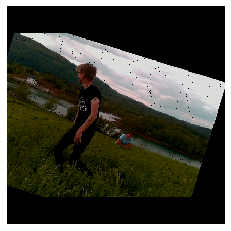

(1) Image
	+ Label: ring1, Conf: 0.99747


<Figure size 432x288 with 0 Axes>

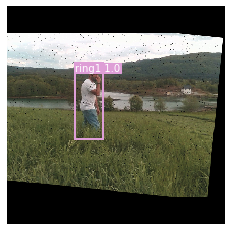

(2) Image
	+ Label: ring1, Conf: 0.99298
	+ Label: ring1, Conf: 0.99108


<Figure size 432x288 with 0 Axes>

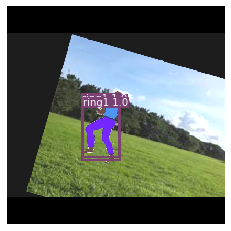

(3) Image
	+ Label: ring2, Conf: 0.98516


<Figure size 432x288 with 0 Axes>

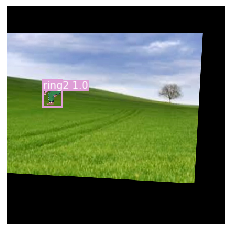

(4) Image


<Figure size 432x288 with 0 Axes>

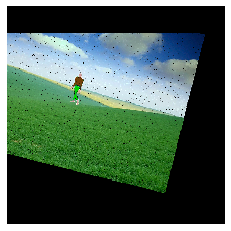

(5) Image
	+ Label: ring1, Conf: 0.99905
	+ Label: ring3, Conf: 0.98600


<Figure size 432x288 with 0 Axes>

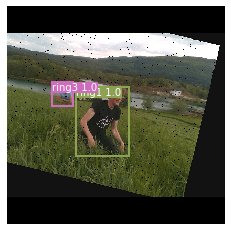

(6) Image
	+ Label: ring3, Conf: 0.98883
	+ Label: ring3, Conf: 0.91109


<Figure size 432x288 with 0 Axes>

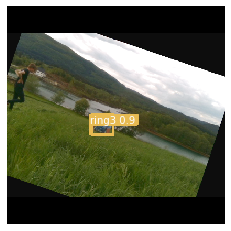

(7) Image


<Figure size 432x288 with 0 Axes>

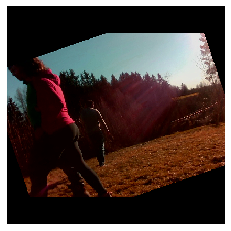

('/home/jose/datasets/simanimation_white/v4/854/Backward/augmented_image_21.jpg', '/home/jose/datasets/house_dataset/registration/bag2/image_9539.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_48038.jpg', '/home/jose/datasets/real_iros2021/image_877.jpg', '/home/jose/datasets/real_iros2021/image_1597.jpg', '/home/jose/datasets/simanimation_white/v4/173/Backward/augmented_image_34.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_413.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_48811.jpg') tensor([[0.0000, 3.0000, 0.5361, 0.5914, 0.0994, 0.1158],
        [1.0000, 1.0000, 0.3901, 0.5907, 0.1896, 0.4146],
        [1.0000, 2.0000, 0.0732, 0.5223, 0.1463, 0.3462],
        [2.0000, 1.0000, 0.7679, 0.5857, 0.4638, 0.5787],
        [3.0000, 3.0000, 0.5667, 0.3719, 0.1059, 0.2252],
        [3.0000, 1.0000, 0.4002, 0.5785, 0.2222, 0.2193],
        [4.0000, 3.0000, 0.3285, 0.3546, 0.0717, 0.1046],
        [4.0000, 3.0000, 0.2656, 0.3291, 0.0838

<Figure size 432x288 with 0 Axes>

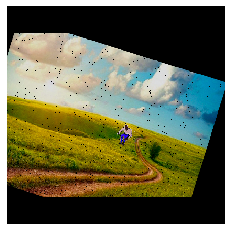

(1) Image
	+ Label: ring1, Conf: 0.99953
	+ Label: ring1, Conf: 0.99666


<Figure size 432x288 with 0 Axes>

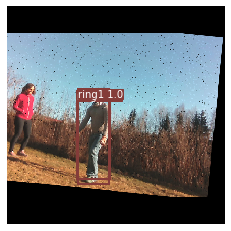

(2) Image


<Figure size 432x288 with 0 Axes>

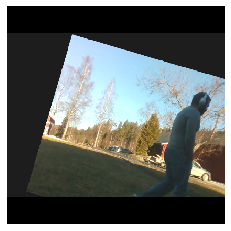

(3) Image
	+ Label: ring2, Conf: 0.99257
	+ Label: ring1, Conf: 0.97806
	+ Label: ring1, Conf: 0.98568
	+ Label: ring2, Conf: 0.95204


<Figure size 432x288 with 0 Axes>

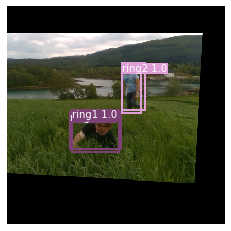

(4) Image
	+ Label: ring3, Conf: 0.99954
	+ Label: ring3, Conf: 0.99968
	+ Label: ring3, Conf: 0.99874


<Figure size 432x288 with 0 Axes>

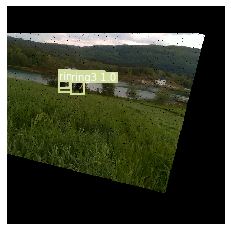

(5) Image


<Figure size 432x288 with 0 Axes>

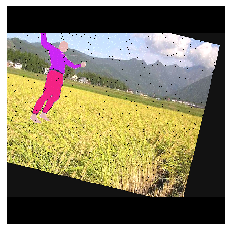

(6) Image
	+ Label: ring2, Conf: 0.99201


<Figure size 432x288 with 0 Axes>

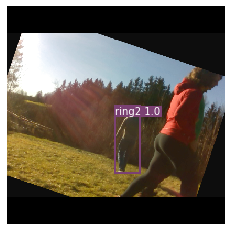

(7) Image


<Figure size 432x288 with 0 Axes>

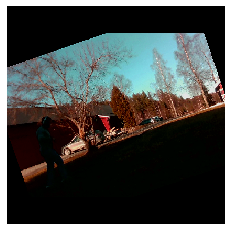

('/home/jose/datasets/house_dataset/registration/bag1/image_46919.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_2950.jpg', '/home/jose/datasets/real_iros2021/image_1034.jpg', '/home/jose/datasets/real_iros2021/image_1428.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_3624.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_46029.jpg', '/home/jose/datasets/house_dataset/registration/bag2/image_9970.jpg', '/home/jose/datasets/simanimation_white/v4/232/Backward/augmented_image_14.jpg') tensor([[0.0000, 2.0000, 0.3302, 0.5747, 0.1861, 0.3247],
        [1.0000, 1.0000, 0.1187, 0.4283, 0.2373, 0.6066],
        [1.0000, 2.0000, 0.4331, 0.5071, 0.1382, 0.3017],
        [1.0000, 0.0000, 0.7114, 0.4937, 0.2987, 0.7374],
        [2.0000, 1.0000, 0.5577, 0.7594, 0.2791, 0.2313],
        [2.0000, 3.0000, 0.7943, 0.6813, 0.1056, 0.0940],
        [3.0000, 3.0000, 0.1914, 0.3681, 0.0785, 0.1521],
        [3.0000, 3.0000, 0.3686, 0.3890, 0.0674, 0.1204]

<Figure size 432x288 with 0 Axes>

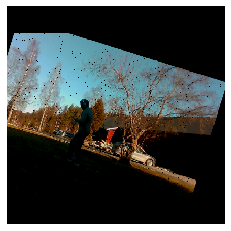

(1) Image
	+ Label: ring1, Conf: 0.95232
	+ Label: ring2, Conf: 0.86210


<Figure size 432x288 with 0 Axes>

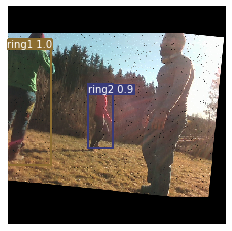

(2) Image
	+ Label: ring1, Conf: 0.52319


<Figure size 432x288 with 0 Axes>

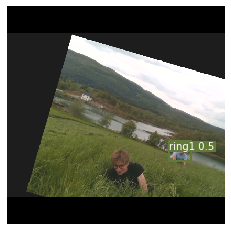

(3) Image
	+ Label: ring3, Conf: 0.99997
	+ Label: ring3, Conf: 0.99985
	+ Label: ring3, Conf: 0.97349
	+ Label: ring3, Conf: 0.90247


<Figure size 432x288 with 0 Axes>

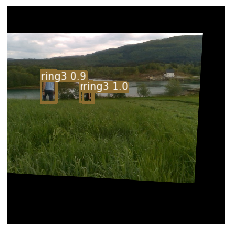

(4) Image
	+ Label: ring3, Conf: 0.29317


<Figure size 432x288 with 0 Axes>

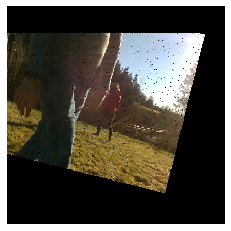

(5) Image


<Figure size 432x288 with 0 Axes>

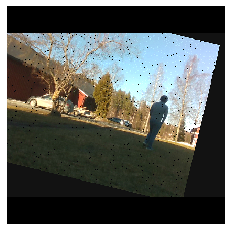

(6) Image
	+ Label: ring0, Conf: 0.99708
	+ Label: ring1, Conf: 0.89086
	+ Label: ring1, Conf: 0.61959


<Figure size 432x288 with 0 Axes>

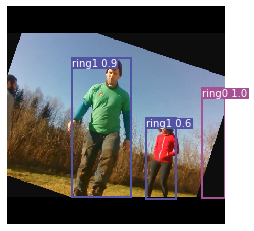

(7) Image
	+ Label: ring3, Conf: 0.98482
	+ Label: ring3, Conf: 0.97238


<Figure size 432x288 with 0 Axes>

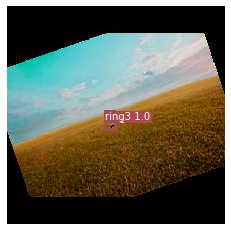

('/home/jose/datasets/simanimation_white/v4/243/Forward/augmented_image_24.jpg', '/home/jose/datasets/simanimation_white/v4/340/Backward/augmented_image_26.jpg', '/home/jose/datasets/house_dataset/registration/bag2/image_9296.jpg', '/home/jose/datasets/simanimation_white/v4/466/Forward/augmented_image_3.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_48637.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1306.jpg', '/home/jose/datasets/house_dataset/registration/bag2/image_9245.jpg', '/home/jose/datasets/simanimation_white/v4/480/Backward/augmented_image_31.jpg') tensor([[0.0000, 3.0000, 0.5461, 0.5962, 0.0793, 0.0988],
        [1.0000, 1.0000, 0.1525, 0.4395, 0.1313, 0.2641],
        [2.0000, 2.0000, 0.8045, 0.7451, 0.2226, 0.2597],
        [3.0000, 0.0000, 0.7785, 0.4464, 0.2297, 0.6303],
        [4.0000, 1.0000, 0.7482, 0.5051, 0.2510, 0.5699],
        [5.0000, 1.0000, 0.1367, 0.4099, 0.2734, 0.5698],
        [5.0000, 2.0000, 0.4391, 0.4642, 0.2273, 

<Figure size 432x288 with 0 Axes>

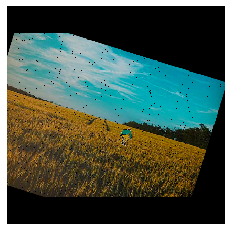

(1) Image
	+ Label: ring1, Conf: 0.98990


<Figure size 432x288 with 0 Axes>

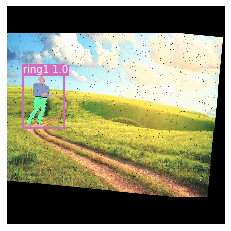

(2) Image
	+ Label: ring2, Conf: 0.52956
	+ Label: ring2, Conf: 0.33963


<Figure size 432x288 with 0 Axes>

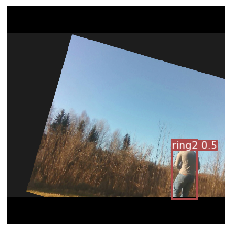

(3) Image


<Figure size 432x288 with 0 Axes>

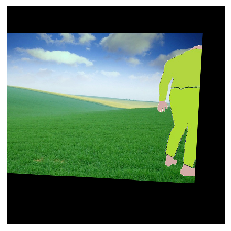

(4) Image
	+ Label: ring1, Conf: 0.96786


<Figure size 432x288 with 0 Axes>

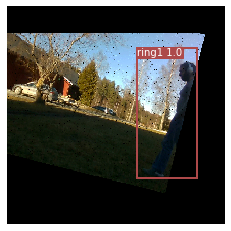

(5) Image


<Figure size 432x288 with 0 Axes>

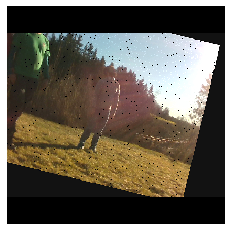

(6) Image
	+ Label: ring1, Conf: 0.99954


<Figure size 432x288 with 0 Axes>

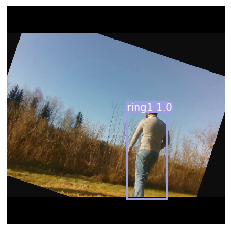

(7) Image
	+ Label: ring1, Conf: 0.80459
	+ Label: ring1, Conf: 0.81299


<Figure size 432x288 with 0 Axes>

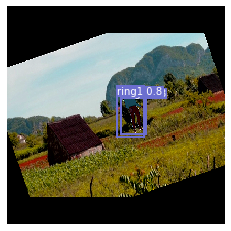

('/home/jose/datasets/house_dataset/registration/bag1/image_48261.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_3229.jpg', '/home/jose/datasets/real_iros2021/image_844.jpg', '/home/jose/datasets/real_iros2021/image_2101.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_47996.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_45942.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_46948.jpg', '/home/jose/datasets/simanimation_white/v4/400/Backward/augmented_image_32.jpg') tensor([[0.0000, 2.0000, 0.6958, 0.6853, 0.2380, 0.3794],
        [1.0000, 1.0000, 0.3465, 0.4837, 0.3368, 0.7174],
        [1.0000, 1.0000, 0.5293, 0.5027, 0.2539, 0.5488],
        [1.0000, 1.0000, 0.5984, 0.4719, 0.1712, 0.5220],
        [2.0000, 1.0000, 0.8033, 0.6235, 0.3933, 0.5031],
        [2.0000, 3.0000, 0.3898, 0.4833, 0.1631, 0.2575],
        [3.0000, 3.0000, 0.3872, 0.3916, 0.1061, 0.1444],
        [4.0000, 1.0000, 0.6887, 0.4867, 0.4095, 0.7234

<Figure size 432x288 with 0 Axes>

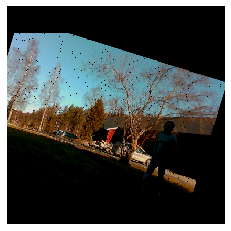

(1) Image
	+ Label: ring1, Conf: 0.99564
	+ Label: ring1, Conf: 0.99951
	+ Label: ring1, Conf: 0.99840
	+ Label: ring1, Conf: 0.99823


<Figure size 432x288 with 0 Axes>

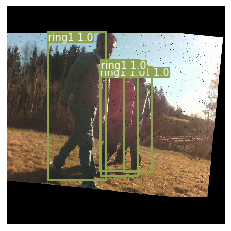

(2) Image
	+ Label: ring2, Conf: 0.98199


<Figure size 432x288 with 0 Axes>

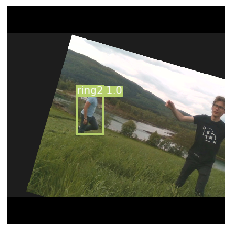

(3) Image
	+ Label: ring3, Conf: 0.89850
	+ Label: ring2, Conf: 0.52613


<Figure size 432x288 with 0 Axes>

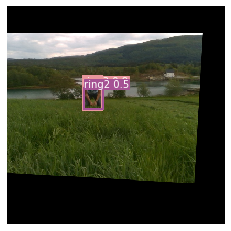

(4) Image
	+ Label: ring1, Conf: 0.97131
	+ Label: ring1, Conf: 0.97564


<Figure size 432x288 with 0 Axes>

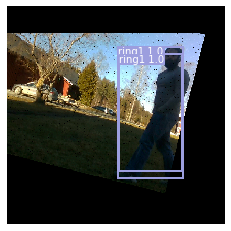

(5) Image


<Figure size 432x288 with 0 Axes>

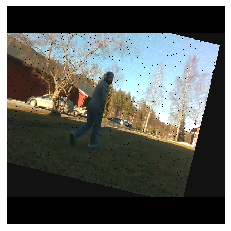

(6) Image


<Figure size 432x288 with 0 Axes>

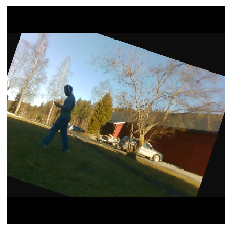

(7) Image
	+ Label: ring1, Conf: 0.99559
	+ Label: ring1, Conf: 0.99176


<Figure size 432x288 with 0 Axes>

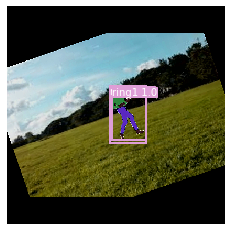

('/home/jose/datasets/real_iros2021/image_2034.jpg', '/home/jose/datasets/real_iros2021/image_1085.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1208.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_2833.jpg', '/home/jose/datasets/real_iros2021/image_1113.jpg', '/home/jose/datasets/real_iros2021/image_1729.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1587.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_3364.jpg') tensor([[0.0000, 3.0000, 0.3824, 0.5124, 0.1224, 0.1809],
        [1.0000, 1.0000, 0.5243, 0.5367, 0.2764, 0.3603],
        [1.0000, 3.0000, 0.3178, 0.4672, 0.1058, 0.1030],
        [2.0000, 1.0000, 0.6868, 0.6508, 0.2762, 0.4483],
        [3.0000, 1.0000, 0.4198, 0.4529, 0.1643, 0.4058],
        [3.0000, 0.0000, 0.6623, 0.4683, 0.4523, 0.6867],
        [4.0000, 1.0000, 0.3526, 0.4573, 0.3049, 0.3492],
        [4.0000, 3.0000, 0.1974, 0.3506, 0.0975, 0.0997],
        [5.0000, 3.0000, 0.3404, 0.4003, 0.0631

<Figure size 432x288 with 0 Axes>

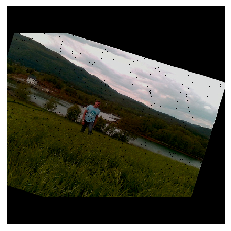

(1) Image
	+ Label: ring1, Conf: 0.99822
	+ Label: ring3, Conf: 0.99555


<Figure size 432x288 with 0 Axes>

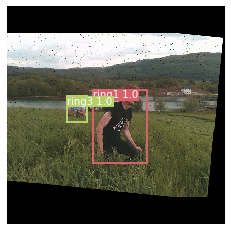

(2) Image
	+ Label: ring1, Conf: 0.99478
	+ Label: ring1, Conf: 0.98956


<Figure size 432x288 with 0 Axes>

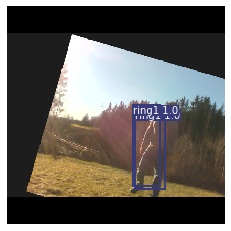

(3) Image
	+ Label: ring1, Conf: 0.99715
	+ Label: ring0, Conf: 0.99953
	+ Label: ring0, Conf: 0.99951


<Figure size 432x288 with 0 Axes>

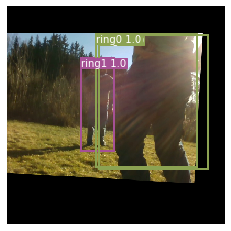

(4) Image
	+ Label: ring1, Conf: 0.99968
	+ Label: ring3, Conf: 0.95792


<Figure size 432x288 with 0 Axes>

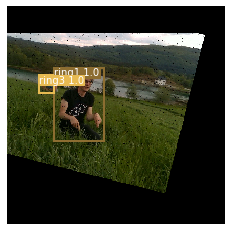

(5) Image
	+ Label: ring1, Conf: 0.96737


<Figure size 432x288 with 0 Axes>

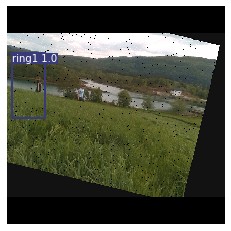

(6) Image


<Figure size 432x288 with 0 Axes>

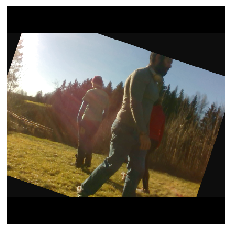

(7) Image
	+ Label: ring1, Conf: 0.80538


<Figure size 432x288 with 0 Axes>

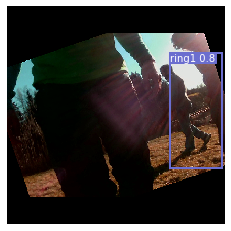

('/home/jose/datasets/house_dataset/registration/bag3/image_2093.jpg', '/home/jose/datasets/simanimation_white/v4/299/Forward/augmented_image_15.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_2825.jpg', '/home/jose/datasets/house_dataset/registration/bag2/image_9289.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_3088.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_2113.jpg', '/home/jose/datasets/house_dataset/registration/bag2/image_9496.jpg', '/home/jose/datasets/real_iros2021/image_1515.jpg') tensor([[0.0000, 2.0000, 0.3602, 0.5889, 0.2238, 0.3418],
        [0.0000, 1.0000, 0.1332, 0.5235, 0.2663, 0.6058],
        [1.0000, 2.0000, 0.5512, 0.4420, 0.1188, 0.2166],
        [2.0000, 0.0000, 0.4325, 0.5140, 0.6585, 0.7220],
        [2.0000, 1.0000, 0.6098, 0.6551, 0.2609, 0.4233],
        [3.0000, 2.0000, 0.2091, 0.5256, 0.1506, 0.3568],
        [4.0000, 1.0000, 0.0477, 0.3511, 0.0954, 0.4522],
        [4.0000, 1.0000, 0.6038, 0.5091, 

<Figure size 432x288 with 0 Axes>

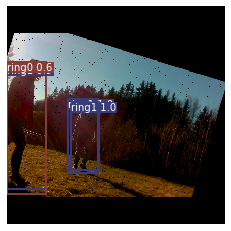

(1) Image
	+ Label: ring1, Conf: 0.82638
	+ Label: ring1, Conf: 0.79464


<Figure size 432x288 with 0 Axes>

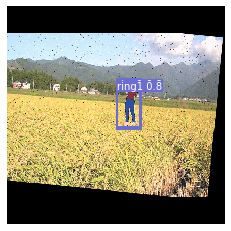

(2) Image


<Figure size 432x288 with 0 Axes>

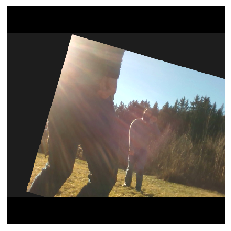

(3) Image
	+ Label: ring1, Conf: 0.98869
	+ Label: ring1, Conf: 0.96696


<Figure size 432x288 with 0 Axes>

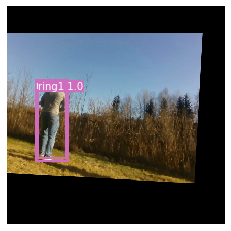

(4) Image
	+ Label: ring1, Conf: 0.93101


<Figure size 432x288 with 0 Axes>

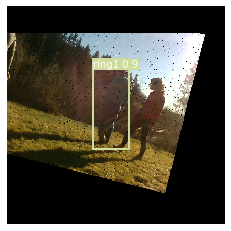

(5) Image
	+ Label: ring1, Conf: 0.98716
	+ Label: ring1, Conf: 0.85317


<Figure size 432x288 with 0 Axes>

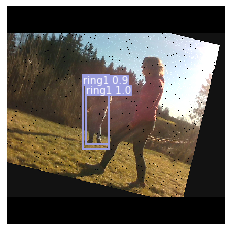

(6) Image
	+ Label: ring1, Conf: 0.86027


<Figure size 432x288 with 0 Axes>

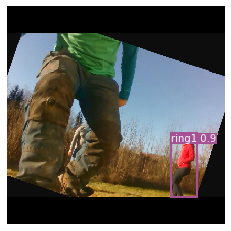

(7) Image


<Figure size 432x288 with 0 Axes>

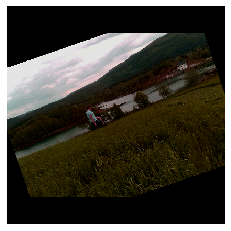

('/home/jose/datasets/house_dataset/registration/bag2/image_9538.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1605.jpg', '/home/jose/datasets/house_dataset/registration/bag2/image_9982.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_2287.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_46969.jpg', '/home/jose/datasets/real_iros2021/image_1065.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_714.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1685.jpg') tensor([[0.0000, 1.0000, 0.4290, 0.6815, 0.2675, 0.3869],
        [0.0000, 2.0000, 0.7529, 0.7300, 0.2130, 0.2901],
        [1.0000, 0.0000, 0.1584, 0.4643, 0.3169, 0.6786],
        [1.0000, 2.0000, 0.3286, 0.4840, 0.1780, 0.4073],
        [1.0000, 2.0000, 0.5558, 0.5210, 0.1675, 0.3939],
        [2.0000, 1.0000, 0.6877, 0.5540, 0.4909, 0.6420],
        [2.0000, 2.0000, 0.8972, 0.7368, 0.2057, 0.2764],
        [2.0000, 1.0000, 0.2090, 0.6454, 0.2235, 0.

<Figure size 432x288 with 0 Axes>

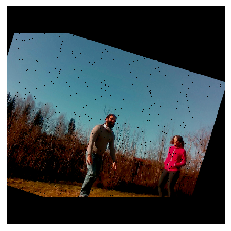

(1) Image
	+ Label: ring0, Conf: 0.99952
	+ Label: ring1, Conf: 0.91384


<Figure size 432x288 with 0 Axes>

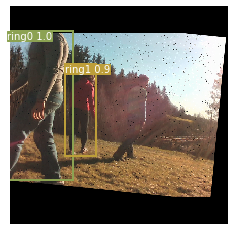

(2) Image
	+ Label: ring0, Conf: 0.92041


<Figure size 432x288 with 0 Axes>

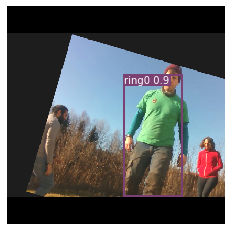

(3) Image
	+ Label: ring1, Conf: 0.97993


<Figure size 432x288 with 0 Axes>

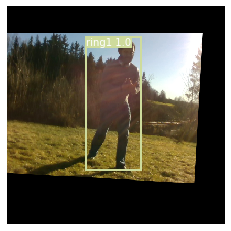

(4) Image
	+ Label: ring2, Conf: 0.97617


<Figure size 432x288 with 0 Axes>

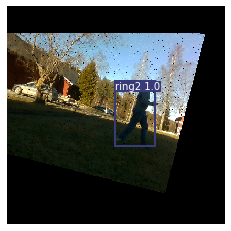

(5) Image
	+ Label: ring1, Conf: 0.99958
	+ Label: ring1, Conf: 0.99706


<Figure size 432x288 with 0 Axes>

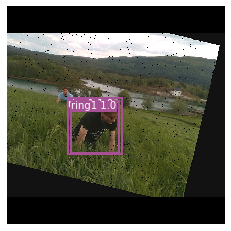

(6) Image
	+ Label: ring1, Conf: 0.97910
	+ Label: ring2, Conf: 0.95145
	+ Label: ring2, Conf: 0.70098


<Figure size 432x288 with 0 Axes>

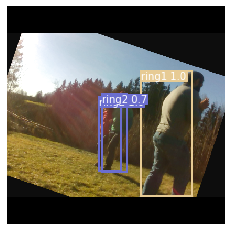

(7) Image


<Figure size 432x288 with 0 Axes>

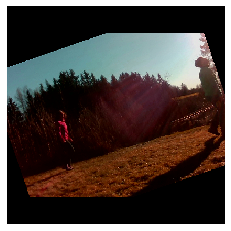

('/home/jose/datasets/house_dataset/registration/bag2/image_9484.jpg', '/home/jose/datasets/simanimation_white/v4/49/Backward/augmented_image_46.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_47423.jpg', '/home/jose/datasets/house_dataset/registration/bag2/image_9806.jpg', '/home/jose/datasets/real_iros2021/image_3489.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1153.jpg', '/home/jose/datasets/real_iros2021/image_1722.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_48215.jpg') tensor([[0.0000e+00, 2.0000e+00, 2.9402e-01, 6.9595e-01, 2.1258e-01, 3.4907e-01],
        [0.0000e+00, 2.0000e+00, 7.8807e-01, 7.3216e-01, 2.0251e-01, 2.8567e-01],
        [0.0000e+00, 0.0000e+00, 1.8811e-01, 4.9696e-01, 3.7623e-01, 7.4392e-01],
        [1.0000e+00, 2.0000e+00, 3.9506e-01, 4.4828e-01, 1.0307e-01, 1.8274e-01],
        [3.0000e+00, 1.0000e+00, 1.7224e-01, 4.8595e-01, 1.8434e-01, 5.1420e-01],
        [3.0000e+00, 2.0000e+00, 2.7163e-01, 5.2751e-

<Figure size 432x288 with 0 Axes>

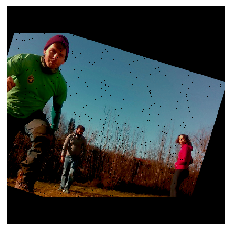

(1) Image
	+ Label: ring1, Conf: 0.78753
	+ Label: ring1, Conf: 0.72416


<Figure size 432x288 with 0 Axes>

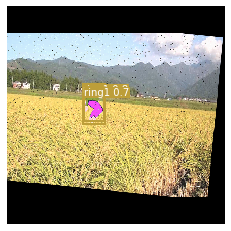

(2) Image


<Figure size 432x288 with 0 Axes>

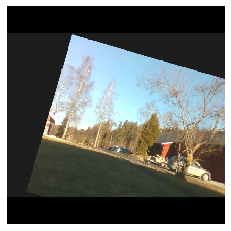

(3) Image
	+ Label: ring1, Conf: 0.99969
	+ Label: ring2, Conf: 0.99801
	+ Label: ring1, Conf: 0.99993


<Figure size 432x288 with 0 Axes>

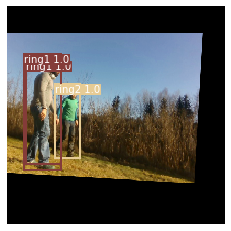

(4) Image


<Figure size 432x288 with 0 Axes>

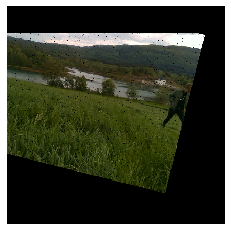

(5) Image


<Figure size 432x288 with 0 Axes>

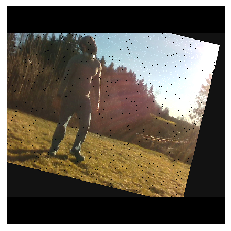

(6) Image
	+ Label: ring3, Conf: 0.99732
	+ Label: ring3, Conf: 0.99691
	+ Label: ring3, Conf: 0.99484
	+ Label: ring3, Conf: 0.99588


<Figure size 432x288 with 0 Axes>

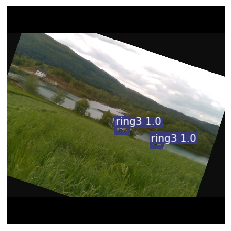

(7) Image


<Figure size 432x288 with 0 Axes>

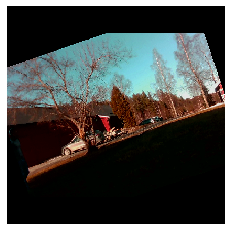

('/home/jose/datasets/house_dataset/registration/bag3/image_1858.jpg', '/home/jose/datasets/simanimation_white/v4/710/Forward/augmented_image_10.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_2632.jpg', '/home/jose/datasets/simanimation_white/v4/338/Forward/augmented_image_1.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_2906.jpg', '/home/jose/datasets/real_iros2021/image_2406.jpg', '/home/jose/datasets/real_iros2021/image_2615.jpg', '/home/jose/datasets/real_iros2021/image_2242.jpg') tensor([[0.0000, 1.0000, 0.2423, 0.5521, 0.3827, 0.4843],
        [0.0000, 3.0000, 0.4147, 0.6239, 0.2027, 0.2787],
        [0.0000, 0.0000, 0.8503, 0.5814, 0.2974, 0.5088],
        [1.0000, 2.0000, 0.2856, 0.4435, 0.1038, 0.1290],
        [2.0000, 1.0000, 0.8465, 0.6346, 0.3070, 0.4809],
        [3.0000, 0.0000, 0.4196, 0.4278, 0.2224, 0.5552],
        [4.0000, 2.0000, 0.0840, 0.3304, 0.1680, 0.3987],
        [4.0000, 0.0000, 0.0874, 0.3849, 0.1749, 0.5199],
        [4

<Figure size 432x288 with 0 Axes>

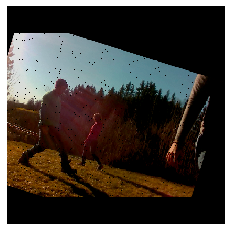

(1) Image
	+ Label: ring2, Conf: 0.77455
	+ Label: ring2, Conf: 0.57883


<Figure size 432x288 with 0 Axes>

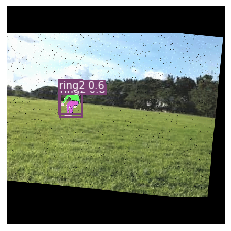

(2) Image


<Figure size 432x288 with 0 Axes>

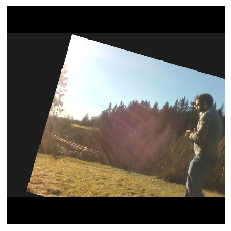

(3) Image
	+ Label: ring0, Conf: 0.99897
	+ Label: ring0, Conf: 0.99993


<Figure size 432x288 with 0 Axes>

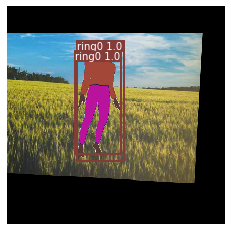

(4) Image
	+ Label: ring1, Conf: 0.99854
	+ Label: ring0, Conf: 0.35931


<Figure size 432x288 with 0 Axes>

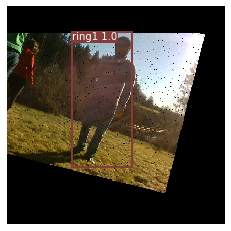

(5) Image
	+ Label: ring2, Conf: 0.74280
	+ Label: ring2, Conf: 0.64359


<Figure size 432x288 with 0 Axes>

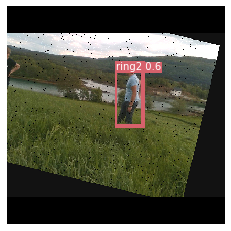

(6) Image
	+ Label: ring2, Conf: 0.99415


<Figure size 432x288 with 0 Axes>

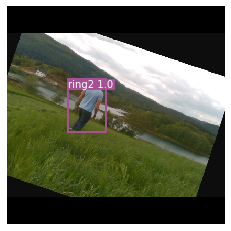

(7) Image


<Figure size 432x288 with 0 Axes>

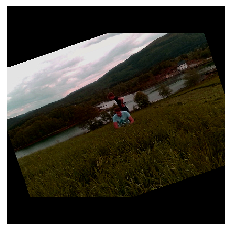

In [23]:
for j in range(10):
    plot_results(j)

In [17]:
c

3